<a href="https://colab.research.google.com/github/nrlopez03/Pooled-Testing/blob/main/Pooled_Testing_Strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Requirements

In [55]:
import pandas as pd
import numpy as np
import random
import math
import itertools
from itertools import combinations
from itertools import combinations_with_replacement
from itertools import product
from itertools import chain
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.linear_model import LinearRegression
import os

plt.rcParams['figure.dpi'] = 300

### Model

In [2]:
# define parameters

B = 2
k = 2
n = 3
G = n

In [3]:
# list of (id, utility, probability of healthy) tuples

def create_agents(n = n):
  agents = list()

  for i in range(n):
    agents.append((i, random.random(), random.random()))
  return agents

agents = create_agents()

print(agents)

[(0, 0.4703055783977068, 0.94354989499802), (1, 0.28181751085620665, 0.36241476344950174), (2, 0.6244523645270501, 0.4351494265145196)]


In [4]:
# print results of a static solver

def printStatic(strategy, utility):
  print(f"\nStatic Strategy, Utility {utility}:")
  i = 1
  for group in strategy:
    if group:
      print(f"Group {i}: {group}")
      i += 1

In [5]:
# print results of a dynamic solver

def printDynamic(strategy, utility = 0, i = 1, greedy = False):
  if utility > 0:
    if greedy:
      print(f"\nGreedy Dynamic Strategy, Utility {utility}:")
    else:
      print(f"\nDynamic Strategy, Utility {utility}:")
  if len(strategy)>0:
    print(f"Test {i}: {strategy[0]}")
    if len(strategy[1]) > 0:
      i+=1
      print(('\t' * (i - 1)) + f"If positive, ", end="")
      printDynamic(strategy[1], 0, i)
    if len(strategy[2]) > 0:
        # i += 1
        print(('\t' * (i - 1)) + f"If negative, ", end="")
        printDynamic(strategy[2], 0, i)

### Maximum Utility

In [6]:
def maxUtil(agents):
  util = 0
  for agent in agents:
    util += agent[1] * agent[2]
  return util

In [7]:
maxUtil(agents)

0.8176216939566006

### Static No Pool

In [8]:
def solveStaticNoPool(agents, B=B):
  utils = []
  for agent in agents:
    utils.append(agent[1] * agent[2])
  utils = sorted(utils, reverse=True)
    # Take the first B elements and sum them
  util = sum(utils[:B])
  return util

### Static Non-Overlapping

Generate and calculate utility of each partition

In [9]:
def solveStaticNonOverlap(agents, G = G, B = B):

  def generate_non_overlapping_subsets(agents, G, B):
    # Generate all possible subsets of agents with sizes up to G
    subsets = []
    for r in range(1, G+1):
        subsets.extend(combinations(agents, r))

    # Generate combinations of B non-overlapping subsets
    combos = combinations(subsets, B)

    # Filter combinations to keep only non-overlapping ones
    non_overlapping_combinations = []
    for combination in combos:
        combined_set = set()
        is_non_overlapping = True
        for subset in combination:
            if combined_set.intersection(subset):
                is_non_overlapping = False
                break
            combined_set.update(subset)
        if is_non_overlapping:
            non_overlapping_combinations.append(combination)

    return non_overlapping_combinations

  def strategyUtilitySNO(combination):
    utility = 0
    for group in combination:
      groupUtility = 0
      groupHealthy = 1
      for person in group:
        groupUtility += person[1]
        groupHealthy *= person[2]
      utility += groupHealthy * groupUtility
    return utility

  strategy = dict()
  combos = generate_non_overlapping_subsets(agents, G, B)
  for combination in combos:
    strategy[combination] = strategyUtilitySNO(combination)
  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

In [10]:
strategy, utility = solveStaticNonOverlap(agents)
printStatic(strategy, utility)


Static Strategy, Utility 0.7154868674237209:
Group 1: ((0, 0.4703055783977068, 0.94354989499802),)
Group 2: ((2, 0.6244523645270501, 0.4351494265145196),)


### Implementation of Bayes' Theorem

In [11]:
def bayesTheorem(agents, posGroups, negAgents):

  posGroups = list(posGroups)
  posGroups = sorted(posGroups, key=len)

  for posGroup in posGroups:
    for posGroupCompare in posGroups:
      if posGroup.issubset(posGroupCompare) and posGroup != posGroupCompare:
        posGroups.remove(posGroupCompare)

  newAgents = []

  for agent in agents:
    if agent[0] in set(negAgents):
      newAgents.append((agent[0], 0, 1))
    else:
      newAgents.append(agent)

  agentDict = {}
  for agent in newAgents:
    agentDict[agent[0]] = (agent[1], agent[2])


  def all_combinations(frozen_sets):

    def pick_at_least_one(agents_set):
      # Generate combinations of different sizes from the set
      combinations_list = []
      for r in range(1, len(agents_set) + 1):
          combinations_list.extend(combinations(agents_set, r))
      return combinations_list

    possibilities = [pick_at_least_one(group) for group in frozen_sets]
    product_result = product(*possibilities)

    # Combine the elements of each tuple into a single set
    combos = {frozenset(chain(*comb)) for comb in product_result}

    return combos

  def getProb(groups):
    involvedAgents = frozenset(chain(*groups))

    possiblePos = all_combinations(groups)

    prob = 0
    for possibility in possiblePos:
      currentOutcome = 1
      for id in involvedAgents:
        if id in possibility:
          currentOutcome *= 1 - agentDict[id][1]
        else:
          currentOutcome *= agentDict[id][1]
      prob += currentOutcome

    return prob

  probPos = {}

  probPos[tuple(posGroups)] = getProb(posGroups)
  probPos[()] = 1

  finalAgents = []

  for agent in newAgents:

    # P(agent is Pos | posGroups) = P(posGroups | agent is Pos) * P(agent in Pos) / P(posGroups)
    # = P(pos Groups agent not in) * P(agent is Pos) / P(posGroups)

    if agent[2] == 1 or agent[2] == 0:
      finalAgents.append(agent)
      # agentDict[agent[0]] = (agent[1], agent[2])

    else:

      posNotIn = [posGroup for posGroup in posGroups if agent[0] not in posGroup]

      if tuple(posNotIn) not in probPos:

        probPos[tuple(posNotIn)] = getProb(posNotIn)

      pAgentPos = probPos[tuple(posNotIn)] * (1 - agent[2]) / probPos[tuple(posGroups)]
      health = 1 - pAgentPos

      finalAgents.append((agent[0], agent[1], health))
      # agentDict[agent[0]] = (agent[1], health)

  for agent in finalAgents:
    agentDict[agent[0]] = (agent[1], agent[2])

  return agentDict

#### Tests with Implementation

Printing Results

In [12]:
def printBayes(agentDict):

  print("Agent, P(Infected), Utility of Testing Negative")

  for ID in agentDict:
    print(f"Agent {ID}: {1 - agentDict[ID][1]}, {agentDict[ID][0]}")

Custom Testing

In [13]:
agents = [(0, 1, 1/2), (1, 1, 1/2), (2, 1, 1/2)]
posGroups = [frozenset({0,1}), frozenset({1,2})]
negAgents = {}
printBayes(bayesTheorem(agents, posGroups, negAgents))

Agent, P(Infected), Utility of Testing Negative
Agent 0: 0.6, 1
Agent 1: 0.8, 1
Agent 2: 0.6, 1


Testing Overlap Results

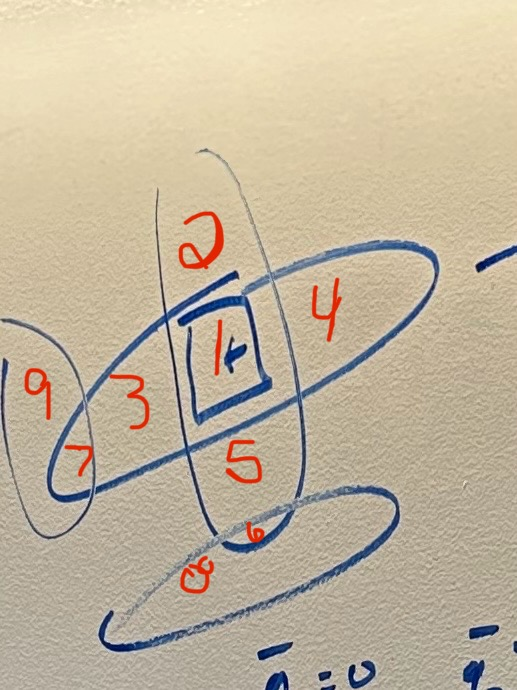

In [14]:
agents = [(i + 1, 1/2, 1/2) for i in range(9)]
posGroups = [frozenset({7, 3, 1, 4}), frozenset({2, 1, 5, 6})]
negAgents = {}
printBayes(bayesTheorem(agents, posGroups, negAgents))

Agent, P(Infected), Utility of Testing Negative
Agent 1: 0.5663716814159292, 0.5
Agent 2: 0.5309734513274337, 0.5
Agent 3: 0.5309734513274337, 0.5
Agent 4: 0.5309734513274337, 0.5
Agent 5: 0.5309734513274337, 0.5
Agent 6: 0.5309734513274337, 0.5
Agent 7: 0.5309734513274337, 0.5
Agent 8: 0.5, 0.5
Agent 9: 0.5, 0.5


In [15]:
agents = [(i + 1, 1/2, 1/2) for i in range(9)]
posGroups = [frozenset({7, 3, 1, 4}), frozenset({2, 1, 5, 6}), frozenset({1})]
negAgents = {}
printBayes(bayesTheorem(agents, posGroups, negAgents))

Agent, P(Infected), Utility of Testing Negative
Agent 1: 1.0, 0.5
Agent 2: 0.5, 0.5
Agent 3: 0.5, 0.5
Agent 4: 0.5, 0.5
Agent 5: 0.5, 0.5
Agent 6: 0.5, 0.5
Agent 7: 0.5, 0.5
Agent 8: 0.5, 0.5
Agent 9: 0.5, 0.5


In [16]:
agents = [(i + 1, 1/2, 1/2) for i in range(9)]
posGroups = [frozenset({7, 3, 1, 4}), frozenset({2, 1, 5, 6}), frozenset({1}), frozenset({8, 6}), frozenset({9, 7})]
negAgents = {}
printBayes(bayesTheorem(agents, posGroups, negAgents))

Agent, P(Infected), Utility of Testing Negative
Agent 1: 1.0, 0.5
Agent 2: 0.5, 0.5
Agent 3: 0.5, 0.5
Agent 4: 0.5, 0.5
Agent 5: 0.5, 0.5
Agent 6: 0.6666666666666666, 0.5
Agent 7: 0.6666666666666666, 0.5
Agent 8: 0.6666666666666666, 0.5
Agent 9: 0.6666666666666666, 0.5


In [17]:
agents = [(i + 1, 1/2, 1/2) for i in range(9)]
posGroups = [frozenset({1}), frozenset({8, 6}), frozenset({9, 7})]
negAgents = {}
printBayes(bayesTheorem(agents, posGroups, negAgents))

Agent, P(Infected), Utility of Testing Negative
Agent 1: 1.0, 0.5
Agent 2: 0.5, 0.5
Agent 3: 0.5, 0.5
Agent 4: 0.5, 0.5
Agent 5: 0.5, 0.5
Agent 6: 0.6666666666666666, 0.5
Agent 7: 0.6666666666666666, 0.5
Agent 8: 0.6666666666666666, 0.5
Agent 9: 0.6666666666666666, 0.5


### Static Overlapping

In [18]:
def solveStaticOverlap(agents, G = G, B = B):

  def generate_overlapping_subsets(agents, G, B):

    # Generate all possible subsets of agents with sizes up to G
    subsets = []
    for r in range(1, G+1):
        subsets.extend(combinations(agents, r))

    # Generate combinations of B subsets without enforcing overlap
    combos = combinations(subsets, B)
    return combos

  def groupHelp(group, posGroups = frozenset(), negAgents = frozenset()):

    groupIDs = frozenset({person[0] for person in group})
    groupUtility = 0
    groupHealthy = 1
    for posGroup in posGroups:
      if posGroup.issubset(groupIDs):
        groupHealthy = 0

    agentDict = bayesTheorem(agents, posGroups, negAgents)

    for person in group:
      groupUtility += agentDict[person[0]][0]
      groupHealthy *= agentDict[person[0]][1]

    groupUtility *= groupHealthy
    return groupHealthy, groupUtility


  def strategyUtility(combination, posGroups = frozenset(), negAgents = frozenset()):

    utility = 0

    if len(combination) > 0:

      firstGroup = combination[0]
      groupIDs = frozenset({person[0] for person in firstGroup})

      firstHealthy, firstUtility = groupHelp(firstGroup, posGroups, negAgents)
      utility += firstUtility

      # positive test
      if firstHealthy < 1:
        posScenario = combination[1:]

        newPosGroups = set(posGroups.copy())

        for posGroup in newPosGroups:
          if groupIDs.issubset(posGroup):
            newPosGroups.remove(posGroup)

        newPosGroups.add(groupIDs.difference(negAgents))

        utility += strategyUtility(posScenario, frozenset(newPosGroups), frozenset(negAgents)) * (1-firstHealthy)

      # negative test
      if firstHealthy > 0:

        negScenario = combination[1:]

        newPosGroups = set()
        for posGroup in posGroups:
          newPosGroups.add(posGroup.difference(groupIDs))

        newNegAgents = set(negAgents.copy())
        newNegAgents.update(groupIDs)

        utility += strategyUtility(negScenario, frozenset(newPosGroups), frozenset(newNegAgents)) * firstHealthy

    return utility

  strategy = dict()
  combos = generate_overlapping_subsets(agents, G, B)
  for combination in combos:
    strategy[combination] = strategyUtility(combination)
  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

In [19]:
agents = [(0, 1, 0.5), (1, 1, 0.5), (2, 1, 1)]
staticStrategy, staticUtility = solveStaticOverlap(agents)
printStatic(staticStrategy, staticUtility)


Static Strategy, Utility 1.75:
Group 1: ((0, 1, 0.5), (2, 1, 1))
Group 2: ((1, 1, 0.5), (2, 1, 1))


In [20]:
agents = [(0, 0.022080006061812485, 0.8205655186482051), (1, 0.760970132052074, 0.5930101907614745), (2, 0.42354957403482274, 0.6984521403961065), (3, 0.006600413727435472, 0.2859953353854493), (4, 0.616360236705176, 0.29752798376295153)]
staticStrategy, staticUtility = solveStaticOverlap(agents, B= 4)
printStatic(staticStrategy, staticUtility)


Static Strategy, Utility 0.9485946598448791:
Group 1: ((0, 0.022080006061812485, 0.8205655186482051),)
Group 2: ((1, 0.760970132052074, 0.5930101907614745),)
Group 3: ((2, 0.42354957403482274, 0.6984521403961065),)
Group 4: ((4, 0.616360236705176, 0.29752798376295153),)


### Dynamic

In [21]:
def solveDynamic(agents, G = G, B = B, posGroups = frozenset(), negAgents = frozenset()):

  if B == 0:
    return [], 0

  def generate_subsets(agents, G=G):
      subsets = []
      for r in range(1, G + 1):
          subsets.extend(combinations(agents, r))
      return subsets

  strategy = dict()
  combos = generate_subsets(agents, G)
  for combination in combos:
    utility = 0

    # first test
    firstTest = combination
    firstUtility = 0
    firstHealthy = 1

    # remaining agents
    remaining = [person for person in agents if person not in firstTest]

    # utility, P(Healthy) of first test
    firstIDs = frozenset({person[0] for person in firstTest})
    if posGroups:
      for posGroup in posGroups:
        if posGroup.issubset(firstIDs):
          firstHealthy = 0
    else:
      posGroups = frozenset()

    agentDict = bayesTheorem(agents, posGroups, negAgents)

    for person in firstTest:
      firstUtility += agentDict[person[0]][0]
      firstHealthy *= agentDict[person[0]][1]
    utility += firstUtility * firstHealthy

    # positive scenario
    if firstHealthy < 1:

      newPosGroups = set(posGroups.copy())
      newPosGroups.add(firstIDs.difference(negAgents))

      posStrategy, posUtility = solveDynamic(agents, G, B-1, frozenset(newPosGroups), frozenset(negAgents))

      utility += (1- firstHealthy) * posUtility

    else:

      posStrategy = []

    # negative scenario

    if remaining and firstHealthy > 0:
      newPosGroups = set()
      for posGroup in posGroups:
        newPosGroups.add(posGroup.difference(firstIDs))

      newNegAgents = set(negAgents.copy())
      newNegAgents.update(firstIDs)


      negStrategy, negUtility = solveDynamic(remaining, G, B-1, frozenset(newPosGroups), frozenset(newNegAgents))
      utility += firstHealthy * negUtility

    else:

      negStrategy = []

    strategy[(tuple(firstTest), tuple(posStrategy), tuple(negStrategy))] = utility

  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

In [22]:
agents = [(0, 1, 0.5), (1, 1, 0.5), (2, 1, 1)]
dynamicStrategy, dynamicUtility = solveDynamic(agents)

printDynamic(dynamicStrategy, dynamicUtility)


Dynamic Strategy, Utility 1.75:
Test 1: ((0, 1, 0.5), (2, 1, 1))
	If positive, Test 2: ((2, 1, 1),)
	If negative, Test 2: ((1, 1, 0.5),)


In [23]:
agents = [(0, 0.129, 0.5562), (1, 0.17483, 1), (2, 0.569, 0.12)]

dynamicStrategy, dynamicUtility = solveDynamic(agents)

printDynamic(dynamicStrategy, dynamicUtility)


Dynamic Strategy, Utility 0.28455713600000004:
Test 1: ((0, 0.129, 0.5562), (1, 0.17483, 1))
	If positive, Test 2: ((1, 0.17483, 1),)
	If negative, Test 2: ((2, 0.569, 0.12),)


### Greedy Dynamic

In [24]:
# test limits per person
d = round(B / 2)

In [25]:
def solveGreedyDynamic(agents, G = G, B = B, d = d, posGroups = frozenset(), negAgents = frozenset(), testCount = dict()):

  if B == 0:
    return [], 0

  def generate_subsets(agents, G=G):
      subsets = []
      for r in range(1, G + 1):
          subsets.extend(combinations(agents, r))
      return subsets

  strategy = dict()
  availAgents = [agent for agent in agents if (not testCount.get(agent[0]) or testCount.get(agent[0]) < d)]
  if len(availAgents) == 0:
    return [], 0

  combos = generate_subsets(availAgents, G)
  for combination in combos:

    utility = 0

    # first test
    firstTest = combination
    firstUtility = 0
    firstHealthy = 1

    # update counts
    newCount = testCount.copy()
    for person in firstTest:
      if not newCount.get(person[0]):
        newCount[person[0]] = 1
      else:
        newCount[person[0]] += 1

    # remaining agents
    remaining = [person for person in agents if person not in firstTest]

    # utility, P(Healthy) of first test
    firstIDs = frozenset({person[0] for person in firstTest})
    if posGroups:
      for posGroup in posGroups:
        if posGroup.issubset(firstIDs):
          firstHealthy = 0
    else:
      posGroups = frozenset()

    agentDict = bayesTheorem(agents, posGroups, negAgents)

    for person in firstTest:
      firstUtility += agentDict[person[0]][0]
      firstHealthy *= agentDict[person[0]][1]
    utility += firstUtility * firstHealthy

    # positive scenario
    if firstHealthy < 1:

      newPosGroups = set(posGroups.copy())
      newPosGroups.add(firstIDs.difference(negAgents))

      posStrategy, posUtility = solveGreedyDynamic(agents, G, B-1, d, frozenset(newPosGroups), frozenset(negAgents), newCount)

      utility += (1- firstHealthy) * posUtility

    else:

      posStrategy = []

    # negative scenario

    if remaining and firstHealthy > 0:
      newPosGroups = set()
      for posGroup in posGroups:
        newPosGroups.add(posGroup.difference(firstIDs))

      newNegAgents = set(negAgents.copy())
      newNegAgents.update(firstIDs)


      negStrategy, negUtility = solveGreedyDynamic(remaining, G, B-1, d, frozenset(newPosGroups), frozenset(newNegAgents), newCount)
      utility += firstHealthy * negUtility

    else:

      negStrategy = []

    strategy[(tuple(firstTest), tuple(posStrategy), tuple(negStrategy))] = utility

  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

In [26]:
agents = [(0, 0.129, 0.5562), (1, 0.17483, 1), (2, 0.569, 0.12)]
dynamicStrategy, dynamicUtility = solveDynamic(agents)
greedyDynamicStrategy, greedyDynamicUtility = solveGreedyDynamic(agents, d=1)

printDynamic(dynamicStrategy, dynamicUtility)
printDynamic(greedyDynamicStrategy, greedyDynamicUtility, greedy=True)


Dynamic Strategy, Utility 0.28455713600000004:
Test 1: ((0, 0.129, 0.5562), (1, 0.17483, 1))
	If positive, Test 2: ((1, 0.17483, 1),)
	If negative, Test 2: ((2, 0.569, 0.12),)

Greedy Dynamic Strategy, Utility 0.24657980000000002:
Test 1: ((0, 0.129, 0.5562),)
	If positive, Test 2: ((1, 0.17483, 1),)
	If negative, Test 2: ((1, 0.17483, 1),)


### Comparing Strategies

#### Custom Testing

In [27]:
agents = [(0, 0.129, 0.5562), (1, 0.17483, 1), (2, 0.569, 0.12)]
staticStrategy, staticUtility = solveStaticOverlap(agents)
dynamicStrategy, dynamicUtility = solveDynamic(agents)
maxUtility = maxUtil(agents)
printDynamic(dynamicStrategy, dynamicUtility)
printStatic(staticStrategy, staticUtility)
print(f"\nRatio: {dynamicUtility/staticUtility}")
print(f"\nMaximum Utility: {maxUtility}")


Dynamic Strategy, Utility 0.28455713600000004:
Test 1: ((0, 0.129, 0.5562), (1, 0.17483, 1))
	If positive, Test 2: ((1, 0.17483, 1),)
	If negative, Test 2: ((2, 0.569, 0.12),)

Static Strategy, Utility 0.24658099248:
Group 1: ((0, 0.129, 0.5562), (1, 0.17483, 1))
Group 2: ((1, 0.17483, 1), (2, 0.569, 0.12))

Ratio: 1.1540108308351473

Maximum Utility: 0.3148598


#### Search for Dynamic-Optimal Strategy

In [30]:
dynamicUtility = 0
staticUtility = 0

while staticUtility >= dynamicUtility:
  agents = create_agents()
  staticStrategy, staticUtility = solveStaticOverlap(agents)
  dynamicStrategy, dynamicUtility = solveDynamic(agents)

print(agents)

printDynamic(dynamicStrategy, dynamicUtility)

printStatic(staticStrategy, staticUtility)

printStatic(solveStaticNonOverlap(agents)[0], solveStaticNonOverlap(agents)[1])

[(0, 0.656166739553009, 0.7807959191483503), (1, 0.17666068225073195, 0.07945940748981761), (2, 0.5512680706452513, 0.118018456533457)]

Dynamic Strategy, Utility 0.5773921193575972:
Test 1: ((2, 0.5512680706452513, 0.118018456533457),)
	If positive, Test 2: ((0, 0.656166739553009, 0.7807959191483503),)
	If negative, Test 2: ((0, 0.656166739553009, 0.7807959191483503),)

Static Strategy, Utility 0.577392119357597:
Group 1: ((0, 0.656166739553009, 0.7807959191483503),)
Group 2: ((2, 0.5512680706452513, 0.118018456533457),)

Static Strategy, Utility 0.577392119357597:
Group 1: ((0, 0.656166739553009, 0.7807959191483503),)
Group 2: ((2, 0.5512680706452513, 0.118018456533457),)


Search for separation between static non-overlapping and static overlapping

In [32]:
dynamicUtility = 0
staticUtility = 0
nonOverlapUtility = 0

while staticUtility >= dynamicUtility or nonOverlapUtility >= staticUtility:
  agents = create_agents()
  staticStrategy, staticUtility = solveStaticOverlap(agents)
  dynamicStrategy, dynamicUtility = solveDynamic(agents)
  nonOverlapStategy, nonOverlapUtility = solveStaticNonOverlap(agents)

print(agents)
printDynamic(dynamicStrategy, dynamicUtility)
printStatic(staticStrategy, staticUtility)

printStatic(nonOverlapStategy, nonOverlapUtility)

[(0, 0.8248217773082355, 0.734256830438899), (1, 0.21094431429636507, 0.5320898228597649), (2, 0.20808201559907902, 0.9089255453380178)]

Dynamic Strategy, Utility 0.819409947839021:
Test 1: ((0, 0.8248217773082355, 0.734256830438899), (2, 0.20808201559907902, 0.9089255453380178))
	If positive, Test 2: ((0, 0.8248217773082355, 0.734256830438899),)
	If negative, Test 2: ((1, 0.21094431429636507, 0.5320898228597649),)

Static Strategy, Utility 0.8181062738265596:
Group 1: ((0, 0.8248217773082355, 0.734256830438899), (2, 0.20808201559907902, 0.9089255453380178))
Group 2: ((1, 0.21094431429636507, 0.5320898228597649), (2, 0.20808201559907902, 0.9089255453380178))

Static Strategy, Utility 0.8082847413919806:
Group 1: ((0, 0.8248217773082355, 0.734256830438899),)
Group 2: ((1, 0.21094431429636507, 0.5320898228597649), (2, 0.20808201559907902, 0.9089255453380178))


#### Ratio-Maximizing Instance Using Random Iterations

In [33]:
n = 3
iters = 100
bestRatio = 0

for _ in range(iters):
  agents = create_agents(n)
  staticStrategy, staticUtility = solveStaticOverlap(agents)
  dynamicStrategy, dynamicUtility = solveDynamic(agents)
  ratio = dynamicUtility / staticUtility
  if ratio > bestRatio:
    bestRatio = ratio
    bestAgents = agents

print(f"A ratio of {bestRatio} has been obtained.")
print(f"We have agents {bestAgents}.")
staticStrategy, staticUtility = solveStaticOverlap(bestAgents)
dynamicStrategy, dynamicUtility = solveDynamic(bestAgents)
printDynamic(dynamicStrategy, dynamicUtility)
printStatic(staticStrategy, staticUtility)

A ratio of 1.0969277569199964 has been obtained.
We have agents [(0, 0.5182902208428727, 0.42803577281070315), (1, 0.8971450526652827, 0.9813939216806691), (2, 0.5084388841927423, 0.595848353324458)].

Dynamic Strategy, Utility 1.3074959577145793:
Test 1: ((1, 0.8971450526652827, 0.9813939216806691), (2, 0.5084388841927423, 0.595848353324458))
	If positive, Test 2: ((1, 0.8971450526652827, 0.9813939216806691),)
	If negative, Test 2: ((0, 0.5182902208428727, 0.42803577281070315),)

Static Strategy, Utility 1.191961776394305:
Group 1: ((0, 0.5182902208428727, 0.42803577281070315), (1, 0.8971450526652827, 0.9813939216806691))
Group 2: ((1, 0.8971450526652827, 0.9813939216806691), (2, 0.5084388841927423, 0.595848353324458))


#### Grid Search for Ratio-Maximizing Instance

In [38]:
# static vs. dynamic

n = 3
def ratios(values):
  if 0 in values:
    return 0
  agents = [(0, values[0], values[1]), (1, values[2], values[3]), (2, values[4], values[5])]
  return solveDynamic(agents)[1]/solveStaticOverlap(agents)[1]

def iterate_combinations(range_max, step_size):
    num_values = int(range_max / step_size) + 1
    values = [i * step_size for i in range(num_values)]
    combinations = itertools.product(values, repeat=n*2)
    max_value = float('-inf')
    max_combination = None
    for combination in combinations:
        func_value = ratios(combination)
        if func_value > max_value:
            max_value = func_value
            max_combination = combination
    return max_combination, max_value

range_max = 1
step_size = 0.25
max_combination, max_value = iterate_combinations(range_max, step_size)
values = max_combination
agents = [(0, values[0], values[1]), (1, values[2], values[3]), (2, values[4], values[5])]
print("Best ratio:", max_value)
staticStrategy, staticUtility = solveStaticOverlap(agents)
dynamicStrategy, dynamicUtility = solveDynamic(agents)
printDynamic(dynamicStrategy, dynamicUtility)
printStatic(staticStrategy, staticUtility)

Best ratio: 1.125

Dynamic Strategy, Utility 0.84375:
Test 1: ((0, 0.5, 0.5), (1, 0.5, 1.0))
	If positive, Test 2: ((1, 0.5, 1.0),)
	If negative, Test 2: ((2, 0.75, 0.25),)

Static Strategy, Utility 0.75:
Group 1: ((0, 0.5, 0.5),)
Group 2: ((1, 0.5, 1.0),)


Grid search with equal utilities:

In [36]:
n = 3

def ratios(values):
  if 0 in values:
    return 0
  agents = [(0, 1, values[0]), (1, 1, values[1]), (2, 1, values[2])]
  return solveDynamic(agents)[1]/solveStaticOverlap(agents)[1]

def iterate_combinations(range_max, step_size):
    num_values = int(range_max / step_size) + 1
    values = [i * step_size for i in range(num_values)]
    combinations = itertools.product(values, repeat=n)
    max_value = float('-inf')
    max_combination = None
    for combination in combinations:
        func_value = ratios(combination)
        if func_value > max_value:
            max_value = func_value
            max_combination = combination
    return max_combination, max_value

range_max = 1
step_size = 0.1
max_combination, max_value = iterate_combinations(range_max, step_size)
values = max_combination
agents = [(0, 1, values[0]), (1, 1, values[1]), (2, 1, values[2])]
print("Best ratio:", max_value)
staticStrategy, staticUtility = solveStaticOverlap(agents)
dynamicStrategy, dynamicUtility = solveDynamic(agents)
printDynamic(dynamicStrategy, dynamicUtility)
printStatic(staticStrategy, staticUtility)

Best ratio: 1.0999999999999999

Dynamic Strategy, Utility 1.65:
Test 1: ((1, 1, 0.5), (2, 1, 1.0))
	If positive, Test 2: ((2, 1, 1.0),)
	If negative, Test 2: ((0, 1, 0.30000000000000004),)

Static Strategy, Utility 1.5:
Group 1: ((1, 1, 0.5),)
Group 2: ((2, 1, 1.0),)


#### Differential Evolution Optimization

##### Static vs. Dynamic

In [39]:
# static vs. dynamic

# Define your objective function (the 'ratio' function)
def ratio(x):
  agents = [(0, x[0], x[1]), (1, x[2], x[3]), (2, x[4], x[5])]
  return -solveDynamic(agents)[1]/solveStaticOverlap(agents)[1]

# Define the bounds for each input variable (assuming they are all between 0 and 1)
bounds = [(0, 1)] * 6

# Run global optimization using differential evolution
result = differential_evolution(ratio, bounds)

# Retrieve the optimal solution
optimal_solution = result.x
optimal_value = result.fun

agents = [(0, optimal_solution[0], optimal_solution[1]), (1, optimal_solution[2], optimal_solution[3]), (2, optimal_solution[4], optimal_solution[5])]
staticStrategy, staticUtility = solveStaticOverlap(agents)
dynamicStrategy, dynamicUtility = solveDynamic(agents)
maxUtility = maxUtil(agents)
print(f"We have agents {agents}.")
printDynamic(dynamicStrategy, dynamicUtility)
printStatic(staticStrategy, staticUtility)
print(f"\nRatio: {dynamicUtility/staticUtility}")
print(f"\nMaximum Utility: {maxUtility}")

We have agents [(0, 0.11724532768063245, 0.5999479771283842), (1, 0.18305518778015967, 0.9613258651863806), (2, 0.8966636294512366, 0.07810574491760025)].

Dynamic Strategy, Utility 0.2839885327113121:
Test 1: ((0, 0.11724532768063245, 0.5999479771283842), (1, 0.18305518778015967, 0.9613258651863806))
	If positive, Test 2: ((1, 0.18305518778015967, 0.9613258651863806),)
	If negative, Test 2: ((2, 0.8966636294512366, 0.07810574491760025),)

Static Strategy, Utility 0.24631678393936735:
Group 1: ((0, 0.11724532768063245, 0.5999479771283842),)
Group 2: ((1, 0.18305518778015967, 0.9613258651863806),)

Ratio: 1.1529402429239979

Maximum Utility: 0.31635136465817526


/tmp/ipykernel_4301/3513338245.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return -solveDynamic(agents)[1]/solveStaticOverlap(agents)[1]


##### Greedy Dynamic vs. Dynamic

In [65]:
N = 3
d = 2
B = 2
G = N

# Define your objective function (the 'ratio' function)
def ratio(x):
    agents = [(i, x[2*i], x[2*i+1]) for i in range(N)]
    # Assuming solveDynamic and solveGreedyDynamic expect a list of tuples for agents
    return -solveDynamic(agents, B=B, G=G)[1] / solveGreedyDynamic(agents, d=d, B=B, G=G)[1]

# Define the bounds for each input variable (assuming they are all between 0 and 1)
def get_bounds(N):
    bounds = []
    for _ in range(N):
        bounds.extend([(0, 1), (0, 1)])  # Assuming each agent's parameters are between 0 and 1
    return bounds

# Run global optimization using differential evolution
bounds = get_bounds(N)
result = differential_evolution(ratio, bounds)

# Retrieve the optimal solution
optimal_solution = result.x
optimal_value = result.fun

agents = [(i, optimal_solution[2*i], optimal_solution[2*i+1]) for i in range(N)]
greedyDynamicStrategy, greedyDynamicUtility = solveGreedyDynamic(agents, d=d, G=G, B=B)
dynamicStrategy, dynamicUtility = solveDynamic(agents, G=G, B=B)
maxUtility = maxUtil(agents)
print(f"We have agents {agents}.")
printDynamic(dynamicStrategy, dynamicUtility)
printDynamic(greedyDynamicStrategy, greedyDynamicUtility, greedy=True)
print(f"\nRatio: {dynamicUtility / greedyDynamicUtility}")
print(f"\nMaximum Utility: {maxUtility}")


We have agents [(0, 0.05627133422867703, 0.3992295322101912), (1, 0.0345343520845684, 0.8292944113923291), (2, 0.0922901535221361, 0.19546124072873938)].

Dynamic Strategy, Utility 0.05324177192077928:
Test 1: ((0, 0.05627133422867703, 0.3992295322101912), (1, 0.0345343520845684, 0.8292944113923291))
	If positive, Test 2: ((1, 0.0345343520845684, 0.8292944113923291),)
	If negative, Test 2: ((2, 0.0922901535221361, 0.19546124072873938),)

Greedy Dynamic Strategy, Utility 0.05324177192077928:
Test 1: ((0, 0.05627133422867703, 0.3992295322101912), (1, 0.0345343520845684, 0.8292944113923291))
	If positive, Test 2: ((1, 0.0345343520845684, 0.8292944113923291),)
	If negative, Test 2: ((2, 0.0922901535221361, 0.19546124072873938),)

Ratio: 1.0

Maximum Utility: 0.06914347154022821


### Graphs

In [27]:
def difEvN(n, B = B, G = G):
  # Define your objective function (the 'ratio' function)
  def ratio(x):
    agents = [(i, x[i*2], x[i*2+1]) for i in range(n)]
    return -solveDynamic(agents, B = B, G = G)[1]/solveStaticOverlap(agents, B = B, G = G)[1]

  # Define the bounds for each input variable (assuming they are all between 0 and 1)
  bounds = [(0, 1)] * (n*2)

  # Run global optimization using differential evolution
  result = differential_evolution(ratio, bounds)

  # Retrieve the optimal solution
  optimal_solution = result.x
  optimal_value = result.fun

  agents = [(i, optimal_solution[i*2], optimal_solution[i*2+1]) for i in range(n)]
  return agents, -optimal_value

In [28]:
difEvN(3)

([(0, 0.6009979781679774, 1.0),
  (1, 0.29136601005016843, 0.6220811425812779),
  (2, 0.8979960851816067, 0.20184197127715653)],
 1.1441407167542446)

In [29]:
def itersN(n, B = B, G = G, iters = 1000):
  bestRatio = 0

  for _ in tqdm(range(iters)):
    agents = create_agents(n)
    staticStrategy, staticUtility = solveStaticOverlap(agents, B = B, G = G)
    dynamicStrategy, dynamicUtility = solveDynamic(agents, B = B, G = G)
    ratio = dynamicUtility / staticUtility
    if ratio > bestRatio:
      bestRatio = ratio
      bestAgents = agents

  return bestAgents, bestRatio

In [30]:
itersN(3)

  0%|          | 0/1000 [00:00<?, ?it/s]

([(0, 0.2654447644364075, 0.9926187361194115),
  (1, 0.6093309387969001, 0.12951249547690014),
  (2, 0.2938290234912103, 0.6852404331499564)],
 1.1012546061064503)

#### Worst-Case Instances by $N$

In [70]:
B = 2
G = 3
lower = 2
upper = 10
agentFunction = itersN

staticNoPool = []
staticNonOverlap = []
staticOverlap = []
dynamic = []
greedyDynamic = []
max_bounds = []

ratios = []

agentHistory = []

for i in tqdm(range(lower, upper + 1)):
  print(f"Calculating for {i} agents")
  bestAgents, ratio = agentFunction(i, B = B, G = G)
  agentHistory.append(bestAgents)
  ratios.append(ratio)
  staticNoPool.append(solveStaticNoPool(bestAgents, B = B))
  staticNonOverlap.append(solveStaticNonOverlap(bestAgents, B = B, G = G)[1])
  staticOverlap.append(solveStaticOverlap(bestAgents, B = B, G = G)[1])
  dynamic.append(solveDynamic(bestAgents, B = B, G = G)[1])
  greedyDynamic.append(solveGreedyDynamic(bestAgents, B = B, G = G, d = max(round(i/2), 2))[1])
  max_bounds.append(maxUtil(bestAgents))

# Normalize
staticNonPool_normalized = [value / staticNoPool[i] for i, value in enumerate(staticNoPool)]
staticNonOverlap_normalized = [value / staticNoPool[i] for i, value in enumerate(staticNonOverlap)]
staticOverlap_normalized = [value / staticNoPool[i] for i, value in enumerate(staticOverlap)]
dynamic_normalized = [value / staticNoPool[i] for i, value in enumerate(dynamic)]
greedyDynamic_normalized = [value / staticNoPool[i] for i, value in enumerate(greedyDynamic)]
max_normalized = [value / staticNoPool[i] for i, value in enumerate(max_bounds)]

# Plot
plt.plot(range(lower, upper + 1), staticNonPool_normalized, label='Static Non-Pooled', color='blue', linestyle='-')
plt.plot(range(lower, upper + 1), staticNonOverlap_normalized, label='Static Non-Overlap', color='green', linestyle='--')
plt.plot(range(lower, upper + 1), staticOverlap_normalized, label='Static Overlap', color='red', linestyle='-.')
plt.plot(range(lower, upper + 1), dynamic_normalized, label='Dynamic', color='orange', linestyle=':')
plt.plot(range(lower, upper + 1), greedyDynamic_normalized, label='Greedy Dynamic', color='brown', linestyle='-')
plt.plot(range(lower, upper + 1), max_normalized, label='Max', color='purple', linestyle='--', linewidth=2, alpha=0.7)

# Add labels and legend
plt.xlabel('N')
plt.ylabel('Normalized Expected Utility')
plt.title(f'Normalized Expected Utility for Ratio Maximizing Agents\nB = {B}, G = {G}, d = max(round(N / 2), 2)')
plt.legend()

# Show plot
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

Calculating for 2 agents


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculating for 3 agents


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculating for 4 agents


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculating for 5 agents


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculating for 6 agents


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculating for 7 agents


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculating for 8 agents


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculating for 9 agents


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculating for 10 agents


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Average Performance Across $N$

  0%|          | 0/9 [00:00<?, ?it/s]

Calculating for 2 agents


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating for 3 agents


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating for 4 agents


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating for 5 agents


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating for 6 agents


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating for 7 agents


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating for 8 agents


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating for 9 agents


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating for 10 agents


  0%|          | 0/100 [00:00<?, ?it/s]

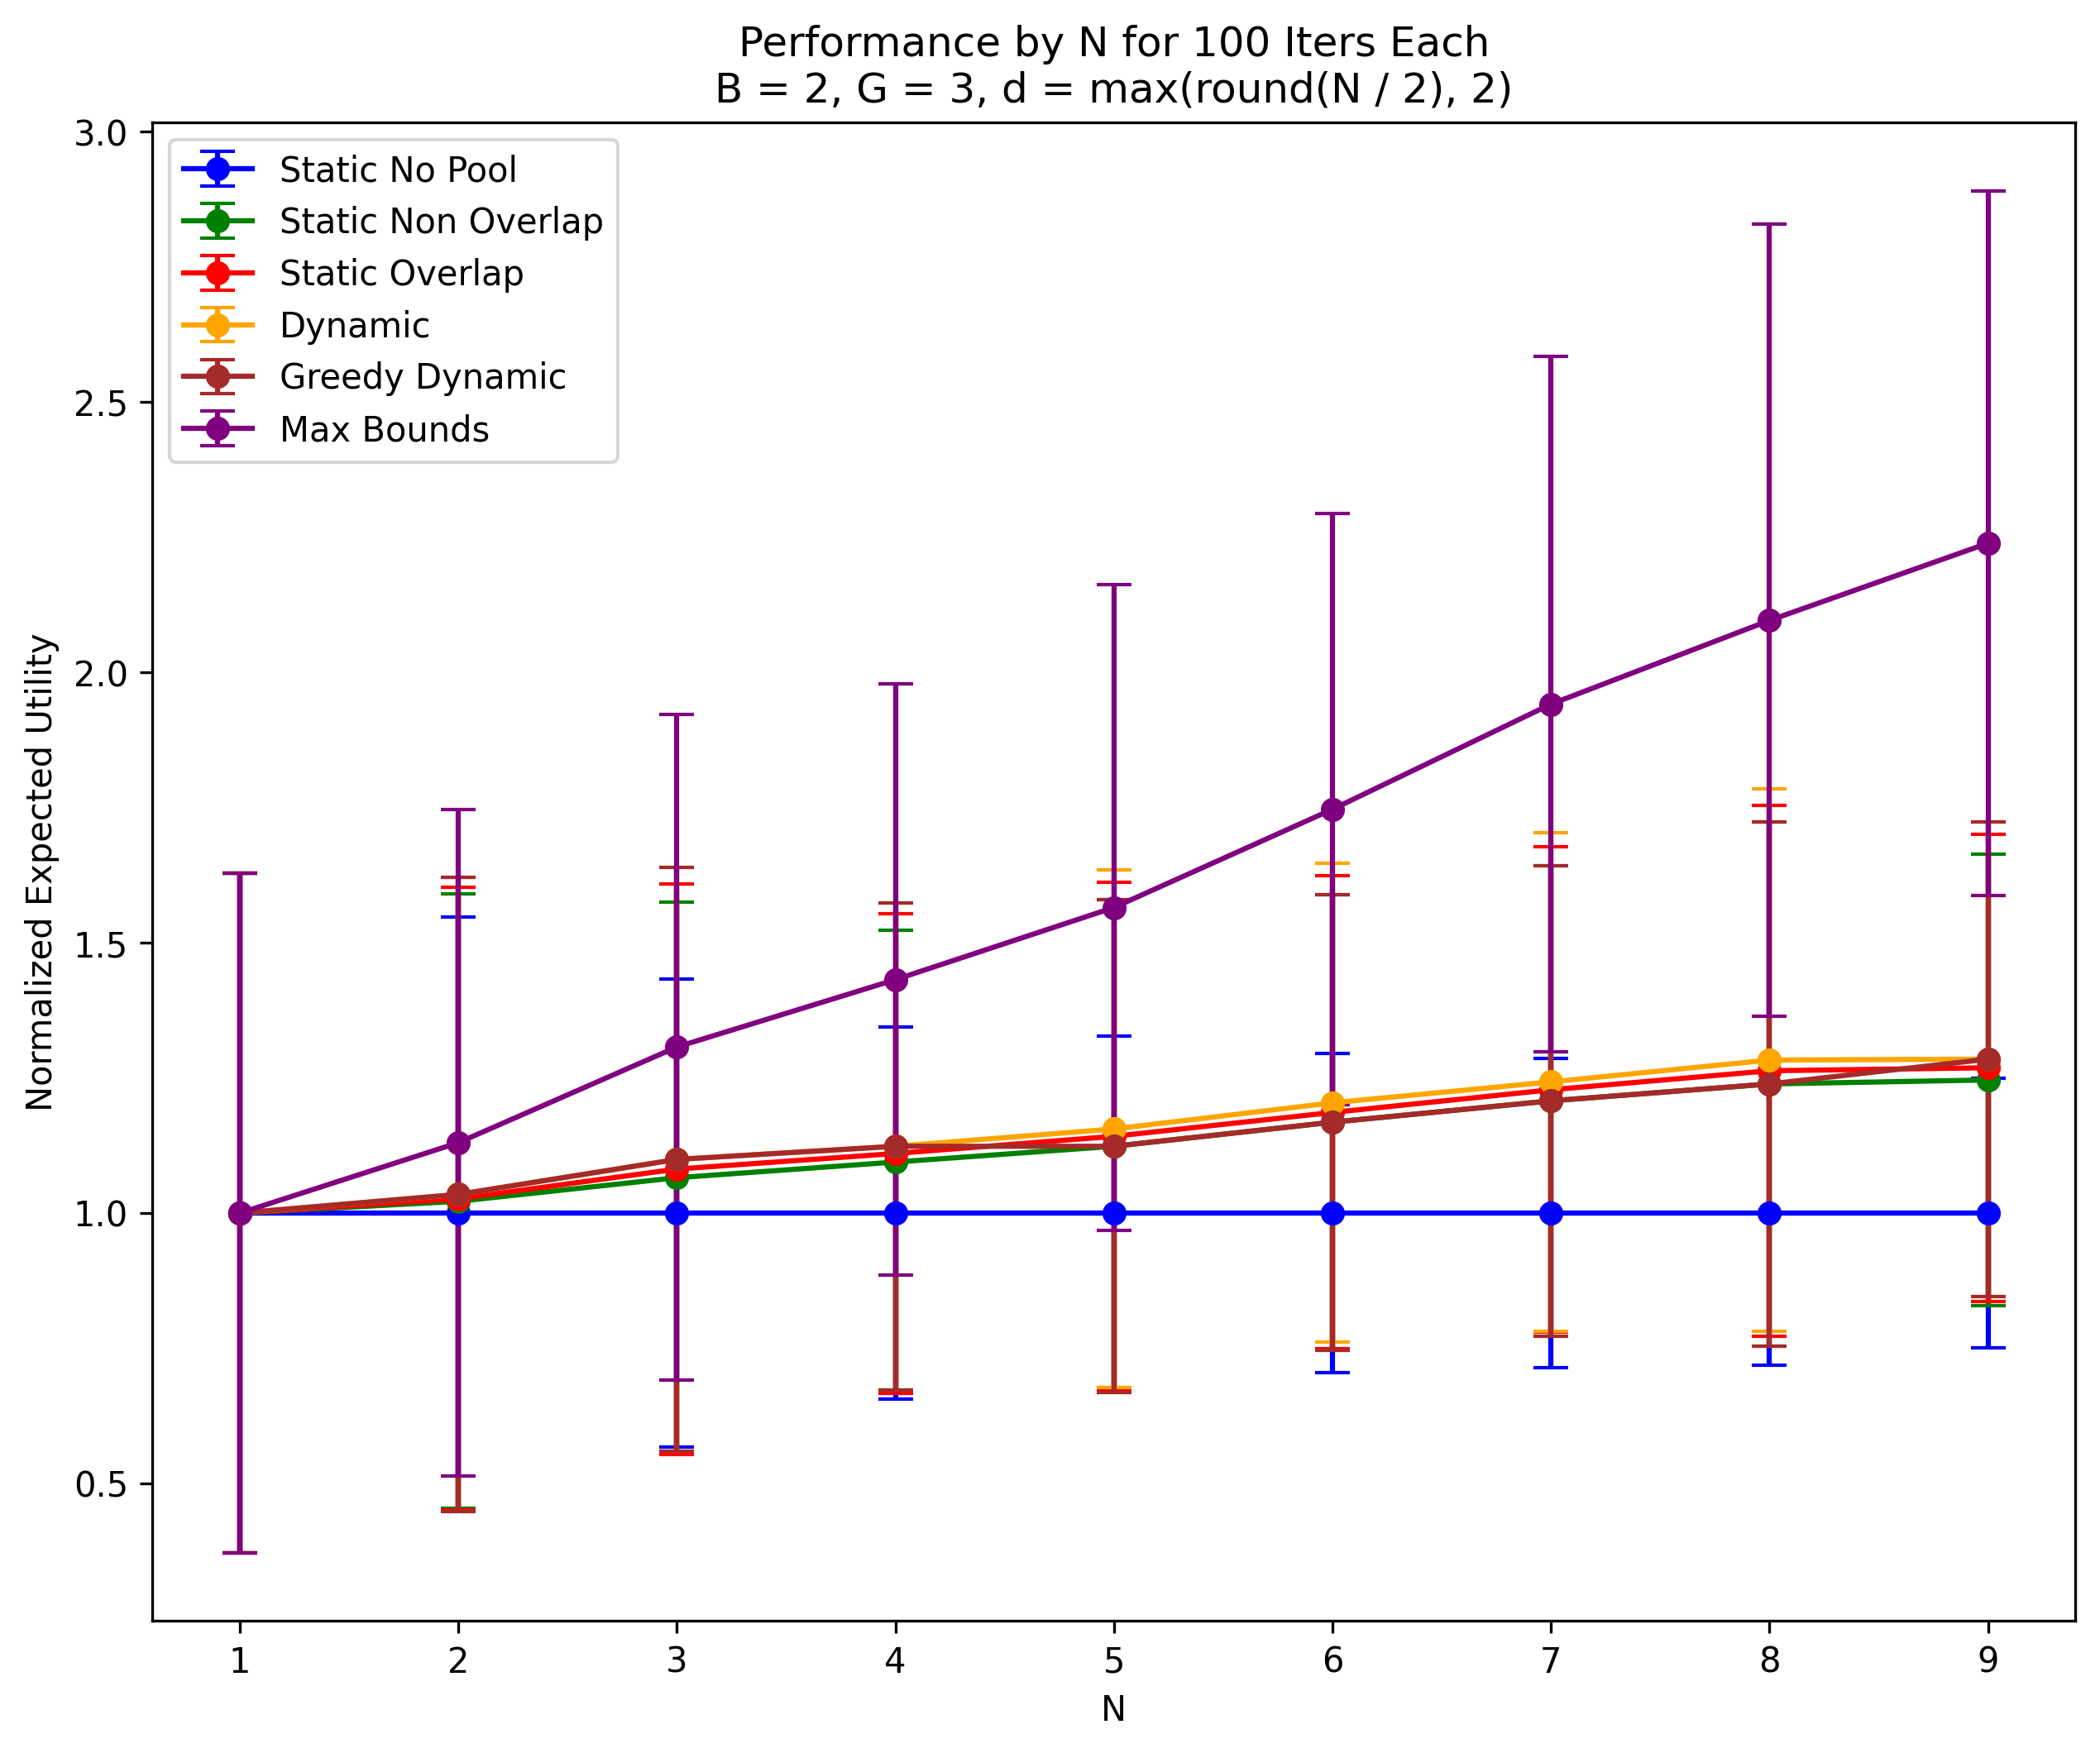

In [ ]:
B = 2
G = 3
iters = 100

lower = 2
upper = 10

staticNoPool = []
staticNonOverlap = []
staticOverlap = []
dynamic = []
greedyDynamic = []
max_bounds = []

for i in tqdm(range(lower, upper + 1)):
  staticNoPool.append([])
  staticNonOverlap.append([])
  staticOverlap.append([])
  dynamic.append([])
  greedyDynamic.append([])
  max_bounds.append([])
  print(f"Calculating for {i} agents")
  for _ in tqdm(range(iters)):
    agents = create_agents(i)
    staticNoPool[-1].append(solveStaticNoPool(agents, B = B))
    staticNonOverlap[-1].append(solveStaticNonOverlap(agents, B = B, G = G)[1])
    staticOverlap[-1].append(solveStaticOverlap(agents, B = B, G = G)[1])
    dynamic[-1].append(solveDynamic(agents, B = B, G = G)[1])
    greedyDynamic[-1].append(solveGreedyDynamic(agents, B = B, G = G, d = max(round(i/2), 2))[1])
    max_bounds[-1].append(maxUtil(agents))

# Calculate average and standard deviation for each index across all lists
average_staticNoPool = np.mean(staticNoPool, axis=1) / np.mean(staticNoPool, axis=1)
std_staticNoPool = np.std(staticNoPool, axis=1) / np.mean(staticNoPool, axis=1)

average_staticNonOverlap = np.mean(staticNonOverlap, axis=1) / np.mean(staticNoPool, axis=1)
std_staticNonOverlap = np.std(staticNonOverlap, axis=1) / np.mean(staticNoPool, axis=1)

average_staticOverlap = np.mean(staticOverlap, axis=1) / np.mean(staticNoPool, axis=1)
std_staticOverlap = np.std(staticOverlap, axis=1) / np.mean(staticNoPool, axis=1)

average_dynamic = np.mean(dynamic, axis=1) / np.mean(staticNoPool, axis=1)
std_dynamic = np.std(dynamic, axis=1) / np.mean(staticNoPool, axis=1)

average_greedyDynamic = np.mean(greedyDynamic, axis=1) / np.mean(staticNoPool, axis=1)
std_greedyDynamic = np.std(greedyDynamic, axis=1) / np.mean(staticNoPool, axis=1)

average_max_bounds = np.mean(max_bounds, axis=1) / np.mean(staticNoPool, axis=1)
std_max_bounds = np.std(max_bounds, axis=1) / np.mean(staticNoPool, axis=1)

# Plot the average values and standard deviations
x_values = range(1, len(average_staticNoPool) + 1)

plt.figure(figsize=(10, 8))

plt.errorbar(x_values, average_staticNoPool, yerr=std_staticNoPool, label='Static No Pool', fmt='o-', color='blue', capsize=5)
plt.errorbar(x_values, average_staticNonOverlap, yerr=std_staticNonOverlap, label='Static Non Overlap', fmt='o-', color='green', capsize=5)
plt.errorbar(x_values, average_staticOverlap, yerr=std_staticOverlap, label='Static Overlap', fmt='o-', color='red', capsize=5)
plt.errorbar(x_values, average_dynamic, yerr=std_dynamic, label='Dynamic', fmt='o-', color='orange', capsize=5)
plt.errorbar(x_values, average_greedyDynamic, yerr=std_greedyDynamic, label='Greedy Dynamic', fmt='o-', color='brown', capsize=5)
plt.errorbar(x_values, average_max_bounds, yerr=std_max_bounds, label='Max Bounds', fmt='o-', color='purple', capsize=5)

# Add labels, title, and legend
plt.xlabel('N')
plt.ylabel('Normalized Expected Utility')
plt.title(f'Performance by N for {iters} Iters Each\nB = {B}, G = {G}, d = max(round(N / 2), 2)')
plt.legend()

# Show plot
plt.show()

#### Average Performance Across $B$

  0%|          | 0/4 [00:00<?, ?it/s]

Calculating for 1 tests


  0%|          | 0/10 [00:00<?, ?it/s]

Calculating for 2 tests


  0%|          | 0/10 [00:00<?, ?it/s]

Calculating for 3 tests


  0%|          | 0/10 [00:00<?, ?it/s]

Calculating for 4 tests


  0%|          | 0/10 [00:00<?, ?it/s]

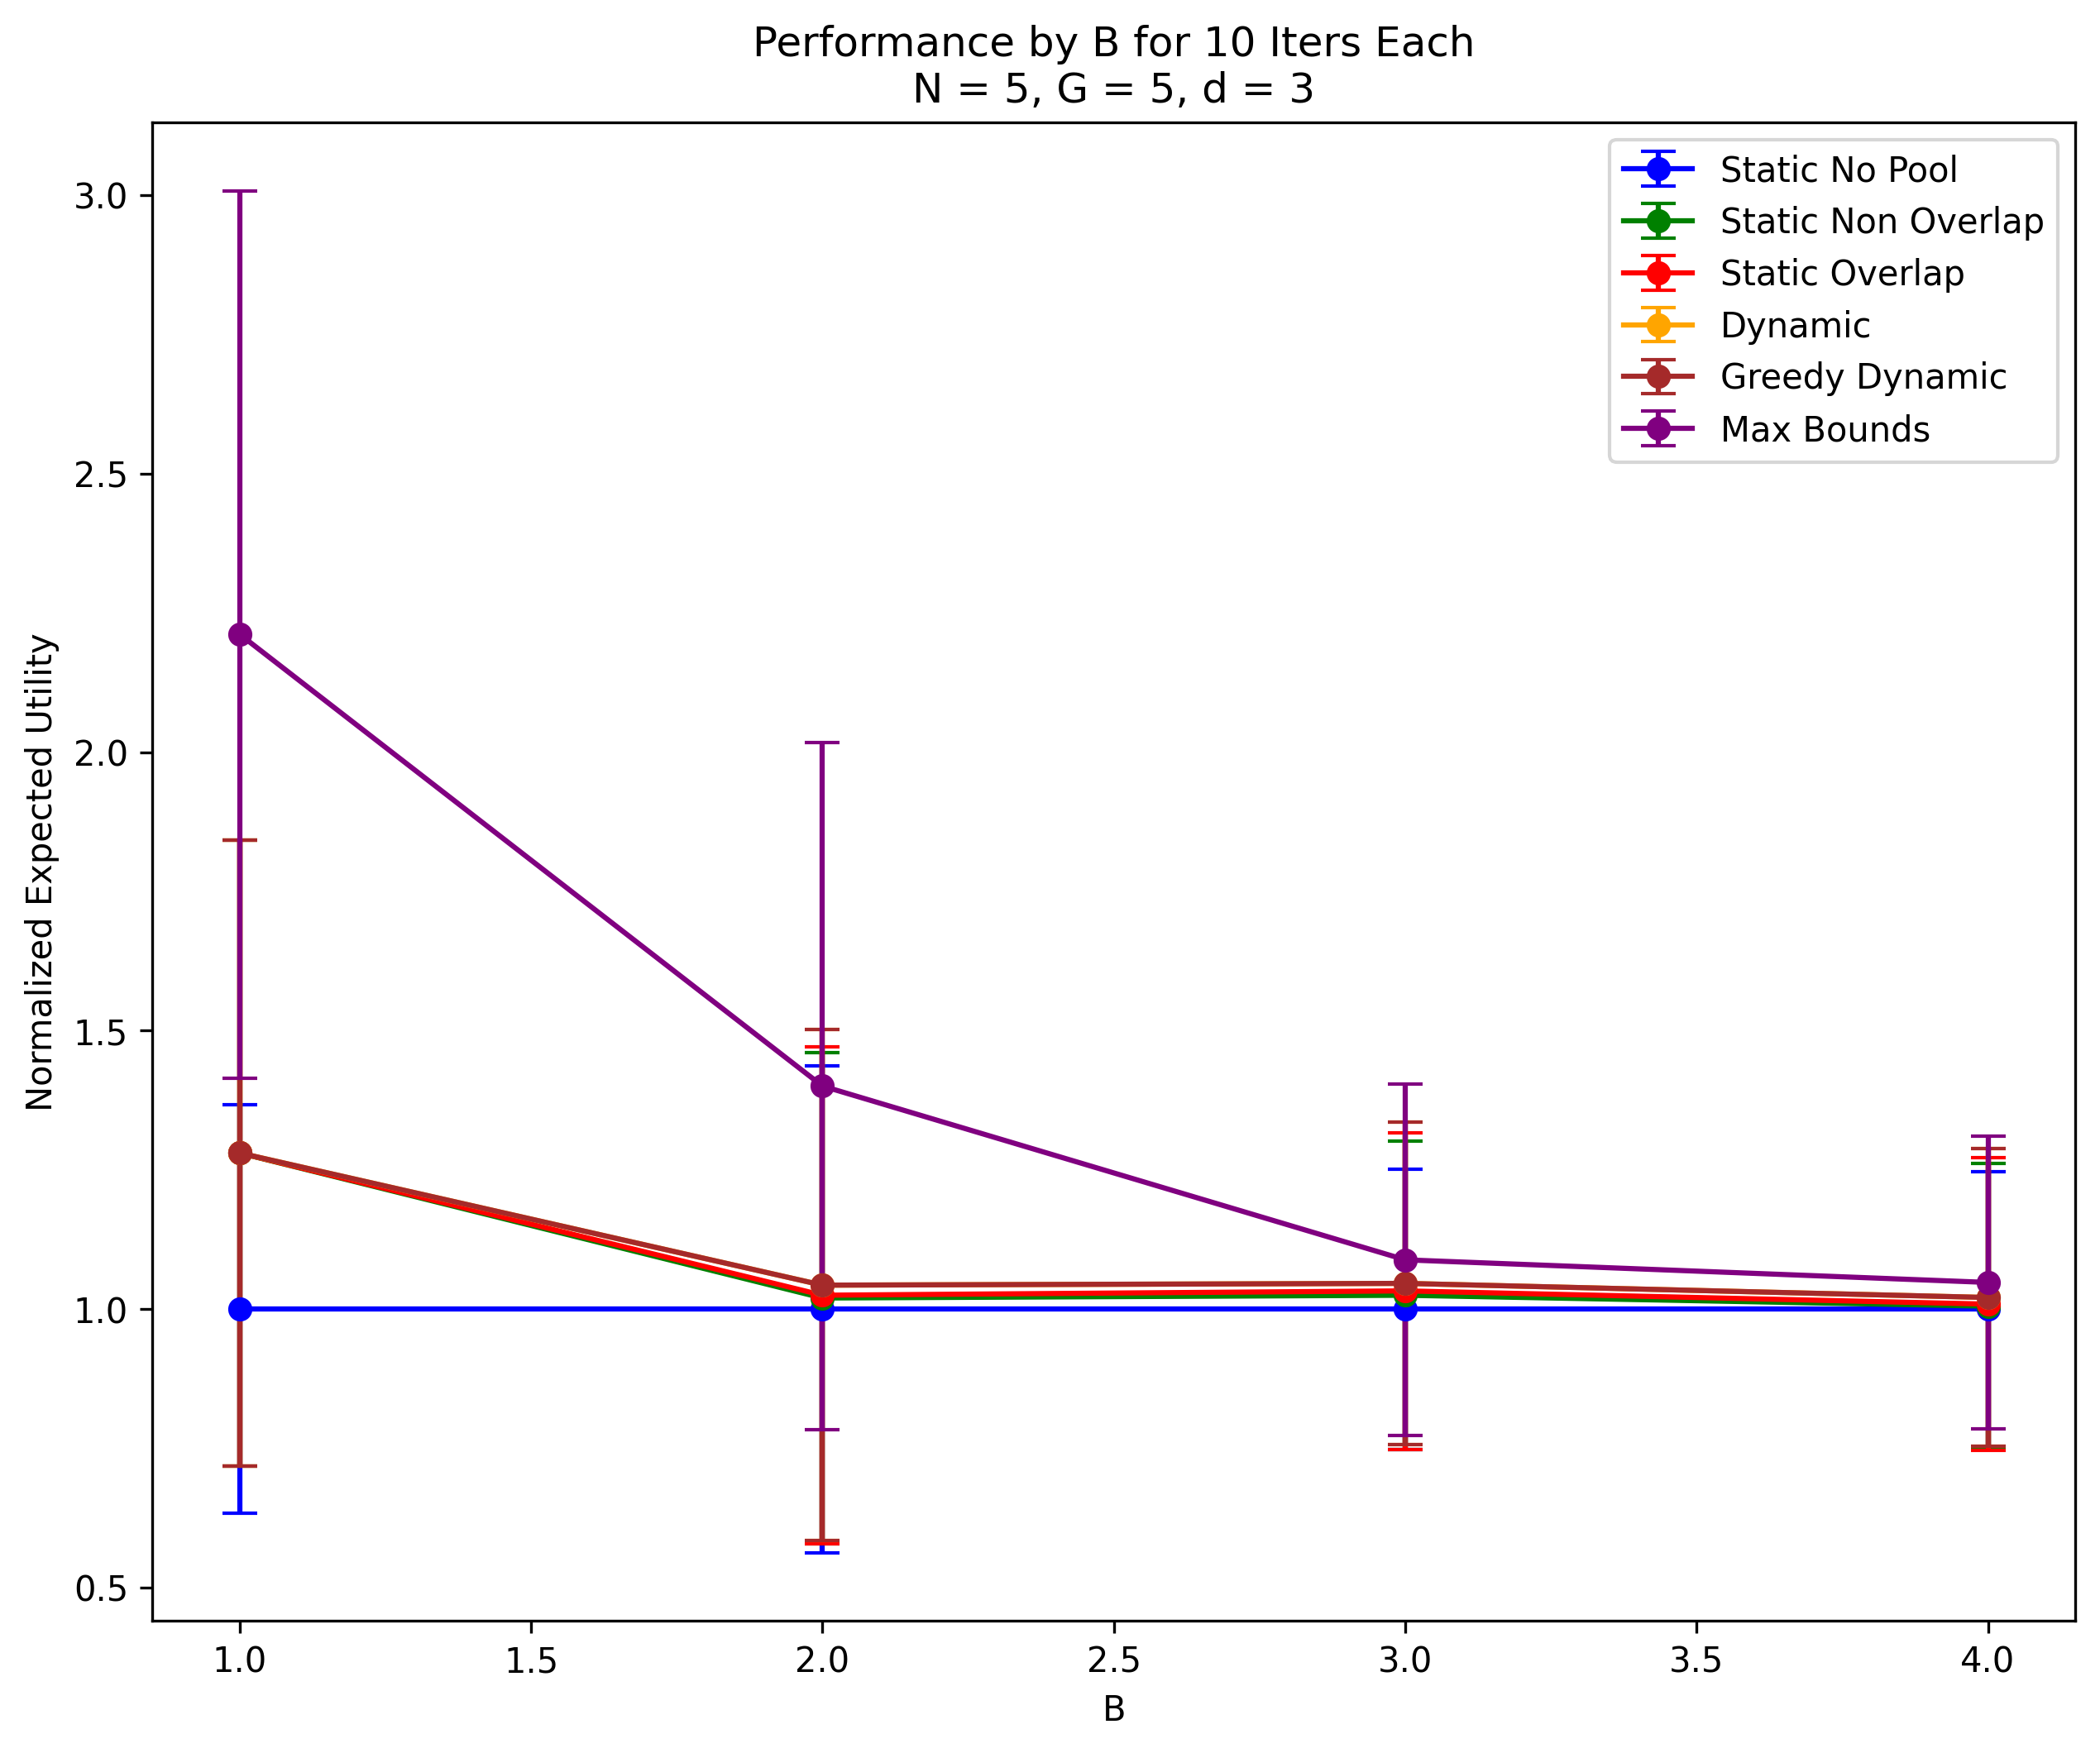

In [34]:
iters = 10

lower = 1
upper = 4

N = 5
G = 5
d = 3

staticNoPool = []
staticNonOverlap = []
staticOverlap = []
dynamic = []
greedyDynamic = []
max_bounds = []

for B in tqdm(range(lower, upper + 1)):
  staticNoPool.append([])
  staticNonOverlap.append([])
  staticOverlap.append([])
  dynamic.append([])
  greedyDynamic.append([])
  max_bounds.append([])
  print(f"Calculating for {B} tests")
  for _ in tqdm(range(iters)):
    agents = create_agents(N)
    staticNoPool[-1].append(solveStaticNoPool(agents, B=B))
    staticNonOverlap[-1].append(solveStaticNonOverlap(agents, B=B, G=G)[1])
    staticOverlap[-1].append(solveStaticOverlap(agents, B=B, G=G)[1])
    dynamic[-1].append(solveDynamic(agents, B=B, G=G)[1])
    greedyDynamic[-1].append(solveGreedyDynamic(agents, B=B, d = d, G=G)[1])
    max_bounds[-1].append(maxUtil(agents))

# Calculate average and standard deviation for each index across all lists
average_staticNoPool = np.mean(staticNoPool, axis=1) / np.mean(staticNoPool, axis=1)
std_staticNoPool = np.std(staticNoPool, axis=1) / np.mean(staticNoPool, axis=1)

average_staticNonOverlap = np.mean(staticNonOverlap, axis=1) / np.mean(staticNoPool, axis=1)
std_staticNonOverlap = np.std(staticNonOverlap, axis=1) / np.mean(staticNoPool, axis=1)

average_staticOverlap = np.mean(staticOverlap, axis=1) / np.mean(staticNoPool, axis=1)
std_staticOverlap = np.std(staticOverlap, axis=1) / np.mean(staticNoPool, axis=1)

average_dynamic = np.mean(dynamic, axis=1) / np.mean(staticNoPool, axis=1)
std_dynamic = np.std(dynamic, axis=1) / np.mean(staticNoPool, axis=1)

average_greedyDynamic = np.mean(greedyDynamic, axis=1) / np.mean(staticNoPool, axis=1)
std_greedyDynamic = np.std(greedyDynamic, axis=1) / np.mean(staticNoPool, axis=1)

average_max_bounds = np.mean(max_bounds, axis=1) / np.mean(staticNoPool, axis=1)
std_max_bounds = np.std(max_bounds, axis=1) / np.mean(staticNoPool, axis=1)

# Plot the average values and standard deviations
x_values = range(1, len(average_staticNoPool) + 1)

plt.figure(figsize=(10, 8))

plt.errorbar(x_values, average_staticNoPool, yerr=std_staticNoPool, label='Static No Pool', fmt='o-', color='blue', capsize=5)
plt.errorbar(x_values, average_staticNonOverlap, yerr=std_staticNonOverlap, label='Static Non Overlap', fmt='o-', color='green', capsize=5)
plt.errorbar(x_values, average_staticOverlap, yerr=std_staticOverlap, label='Static Overlap', fmt='o-', color='red', capsize=5)
plt.errorbar(x_values, average_dynamic, yerr=std_dynamic, label='Dynamic', fmt='o-', color='orange', capsize=5)
plt.errorbar(x_values, average_greedyDynamic, yerr=std_greedyDynamic, label='Greedy Dynamic', fmt='o-', color='brown', capsize=5)
plt.errorbar(x_values, average_max_bounds, yerr=std_max_bounds, label='Max Bounds', fmt='o-', color='purple', capsize=5)

# Add labels, title, and legend
plt.xlabel('B')
plt.ylabel('Normalized Expected Utility')
plt.title(f'Performance by B for {iters} Iters Each\nN = {N}, G = {G}, d = {d}')
plt.legend()

# Show plot
plt.show()

#### Average Performance Across $D$

In [ ]:
N = 10
B = 5
G = 10
iters = 10

lower = 1
upper = 5

staticNoPool = []
staticNonOverlap = []
staticOverlap = []
greedyDynamic = []
dynamic = []
max_bounds = []

for d in tqdm(range(lower, upper + 1)):
  greedyDynamic.append([])

for _ in tqdm(range(iters)):
  agents = create_agents(N)
  staticNoPool.append(solveStaticNoPool(agents, B=B))
  staticNonOverlap.append(solveStaticNonOverlap(agents, B=B, G=G)[1])
  staticOverlap.append(solveStaticOverlap(agents, B=B, G=G)[1])
  dynamic.append(solveDynamic(agents,B=B, G=G)[1])
  max_bounds.append(maxUtil(agents))
  for d in tqdm(range(lower, upper + 1)):
    greedyDynamic[d-lower].append(solveGreedyDynamic(agents, d = d, B=B, G=G)[1])

# Calculate average and standard deviation for each index across all lists
average_staticNoPool = [np.mean(staticNoPool) / np.mean(staticNoPool)] * len(greedyDynamic)
std_staticNoPool = [np.std(staticNoPool) / np.mean(staticNoPool)] * len(greedyDynamic)

average_staticNonOverlap = [np.mean(staticNonOverlap) / np.mean(staticNoPool)] *len(greedyDynamic)
std_staticNonOverlap = [np.std(staticNonOverlap) / np.mean(staticNoPool)] * len(greedyDynamic)

average_staticOverlap = [np.mean(staticOverlap) / np.mean(staticNoPool)] * len(greedyDynamic)
std_staticOverlap = [np.std(staticOverlap) / np.mean(staticNoPool)] * len(greedyDynamic)

average_dynamic = [np.mean(dynamic) / np.mean(staticNoPool)] * len(greedyDynamic)
std_dynamic = [np.std(dynamic) / np.mean(staticNoPool)] * len(greedyDynamic)

average_greedyDynamic = np.mean(greedyDynamic, axis=1) / np.mean(greedyDynamic)
std_greedyDynamic = np.std(greedyDynamic, axis=1) / np.mean(greedyDynamic)

average_max_bounds = [np.mean(max_bounds) / np.mean(staticNoPool)] * len(greedyDynamic)
std_max_bounds = [np.std(max_bounds) / np.mean(staticNoPool)] * len(greedyDynamic)

# Plot the average values and standard deviations
x_values = range(1, len(greedyDynamic) + 1)

plt.figure(figsize=(10, 8))

plt.errorbar(x_values, average_staticNoPool, yerr=std_staticNoPool, label='Static No Pool', fmt='o-', color='blue', capsize=5)
plt.errorbar(x_values, average_staticNonOverlap, yerr=std_staticNonOverlap, label='Static Non Overlap', fmt='o-', color='green', capsize=5)
plt.errorbar(x_values, average_staticOverlap, yerr=std_staticOverlap, label='Static Overlap', fmt='o-', color='red', capsize=5)
plt.errorbar(x_values, average_dynamic, yerr=std_dynamic, label='Dynamic', fmt='o-', color='orange', capsize=5)
plt.errorbar(x_values, average_greedyDynamic, yerr=std_greedyDynamic, label='Greedy Dynamic', fmt='o-', color='brown', capsize=5)
plt.errorbar(x_values, average_max_bounds, yerr=std_max_bounds, label='Max Bounds', fmt='o-', color='purple', capsize=5)

# Add labels, title, and legend
plt.xlabel('D')
plt.ylabel('Normalized Expected Utility')
plt.title(f'Performance by D for {iters} Iters Each\nB = {B}, G = {G}, N = {N}')
plt.legend()

# Show plot
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [37]:
agents = create_agents(7)

In [38]:
strategy, utility = solveDynamic(agents, B=5, G=3)
printDynamic(strategy, utility)

for d in range(1, 6):
    print("\nd:")
    strategy, utility = solveGreedyDynamic(agents, B=5, G=3, d=d)
    printDynamic(strategy, utility)

KeyboardInterrupt: 

### Scatterplots

  0%|          | 0/100 [00:00<?, ?it/s]

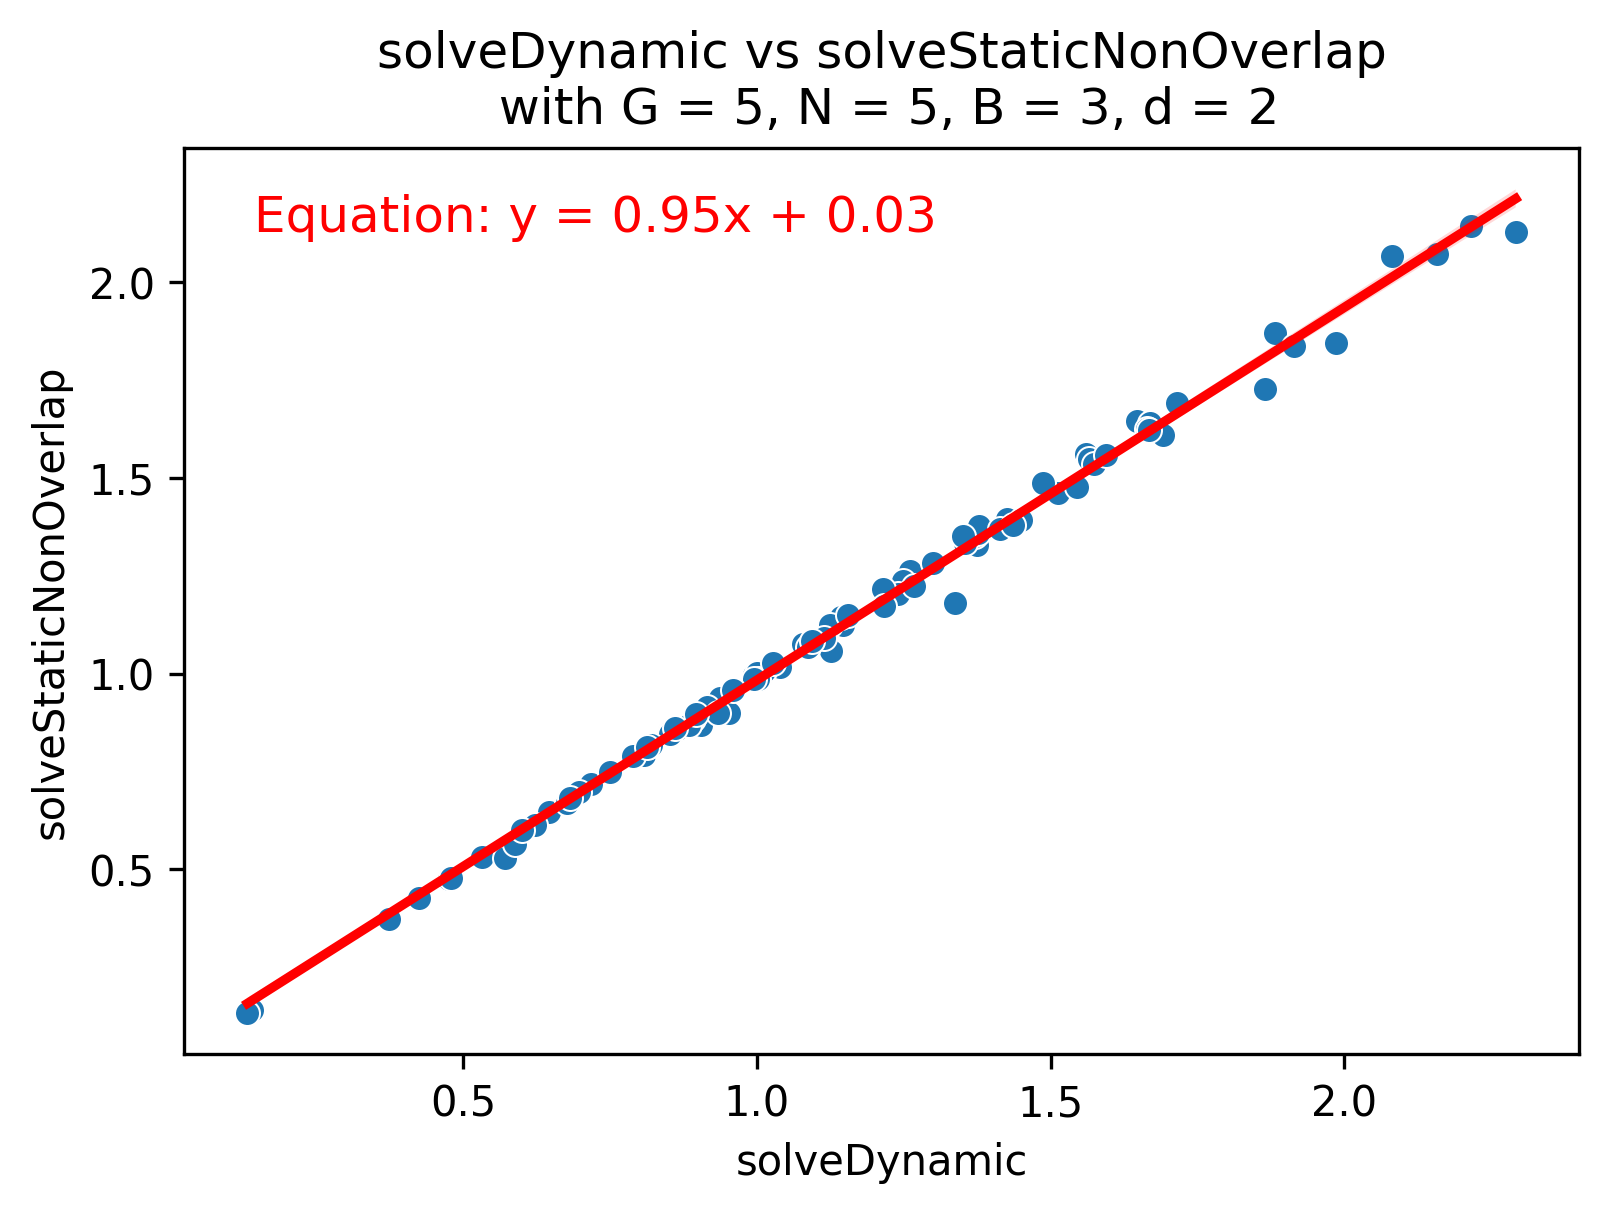

In [54]:
iters = 100

N = 5
d = 2
B = 3
G = N

xAxis = solveDynamic
yAxis = solveStaticNonOverlap

x_results = []
y_results = []

for _ in tqdm(range(iters)):
    agents = create_agents(N)
    x_results.append(xAxis(agents, G, B)[1])
    y_results.append(yAxis(agents, G, B)[1])

# Create a DataFrame with the results
df = pd.DataFrame({
    xAxis.__name__: x_results,
    yAxis.__name__: y_results
})

# Scatter plot with line of best fit
sns.scatterplot(x=df[xAxis.__name__], y=df[yAxis.__name__])

# Fit the line
sns.regplot(x=df[xAxis.__name__], y=df[yAxis.__name__], scatter=False, color="red")

# Linear regression to get the equation of the line
model = LinearRegression()
model.fit(np.array(x_results).reshape(-1, 1), y_results)
slope = model.coef_[0]
intercept = model.intercept_

# Add labels, title, and equation
plt.xlabel(xAxis.__name__)
plt.ylabel(yAxis.__name__)
plt.title(f'{xAxis.__name__} vs {yAxis.__name__}\n with G = {G}, N = {N}, B = {B}, d = {d}')
plt.text(
    0.05, 0.95,
    f'Equation: y = {slope:.2f}x + {intercept:.2f}',
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    color='red'
)

# Show plot
plt.show()

In [60]:
iters = 1000

# Specify the combinations you want to test
target_combinations = [
    {'N': 5, 'd': 2, 'B': 3, 'G': 5},
    {'N': 3, 'd': 2, 'B': 2, 'G': 3},
]

# List of functions to test
functions = [
    solveDynamic, 
    solveStaticOverlap, 
    solveStaticNonOverlap, 
    solveStaticNoPool, 
    solveGreedyDynamic, 
    maxUtil
]  

data_folder = 'data'

# Function to create a unique filename based on the parameters
def create_filename(N, d, B, G):
    return os.path.join(data_folder, f"data_N{N}_d{d}_B{B}_G{G}.csv")

# Iterate over the target combinations of N, d, B
for combo in target_combinations:
    N = combo['N']
    d = combo['d']
    B = combo['B']
    G = combo['G']
    filename = create_filename(N, d, B, G)
    
    # Check if the CSV file already exists
    if os.path.exists(filename):
        print(f"Loading data from {filename}")
        df = pd.read_csv(filename)
        
        # Check if the DataFrame has enough rows
        if len(df) < iters:
            print(f"Existing data has {len(df)} rows, generating additional rows to reach {iters}.")
            needed_rows = iters - len(df)
            results = {f.__name__: [] for f in functions}
            agent_list = []  # List to store created agents
            
            # Generate additional rows
            for _ in tqdm(range(needed_rows)):
                agents = create_agents(N)
                agent_list.append(agents)  # Track the created agents
                for func in functions:
                    # Call each function with the appropriate parameters
                    if func.__name__ == 'solveDynamic' or func.__name__ == 'solveStaticOverlap' or func.__name__ == 'solveStaticNonOverlap':
                        results[func.__name__].append(func(agents, G, B)[1])
                    elif func.__name__ == 'solveStaticNoPool':
                        results[func.__name__].append(func(agents, B))
                    elif func.__name__ == 'solveGreedyDynamic':
                        results[func.__name__].append(func(agents, G, B, d)[1])
                    elif func.__name__ == 'maxUtil':
                        results[func.__name__].append(func(agents))
            
            # Append the new rows to the DataFrame
            new_rows = pd.DataFrame({
                'agents': agent_list,  # Store the created agents
                **results  # Unpack the results dictionary into the DataFrame
            })
            df = pd.concat([df, new_rows], ignore_index=True)
        
    else:
        print(f"Generating data for N={N}, d={d}, B={B}, G={G}")
        
        # Dictionary to store results for each function
        results = {f.__name__: [] for f in functions}
        agent_list = []  # List to store created agents
        
        for _ in tqdm(range(iters)):
            agents = create_agents(N)
            agent_list.append(agents)  # Track the created agents
            for func in functions:
                # Call each function with the appropriate parameters
                if func.__name__ == 'solveDynamic' or func.__name__ == 'solveStaticOverlap' or func.__name__ == 'solveStaticNonOverlap':
                    results[func.__name__].append(func(agents, G, B)[1])
                elif func.__name__ == 'solveStaticNoPool':
                    results[func.__name__].append(func(agents, B))
                elif func.__name__ == 'solveGreedyDynamic':
                    results[func.__name__].append(func(agents, G, B, d)[1])
                elif func.__name__ == 'maxUtil':
                    results[func.__name__].append(func(agents))
        
        # Create a DataFrame with the results
        df = pd.DataFrame({
            'agents': agent_list,  # Store the created agents
            **results  # Unpack the results dictionary into the DataFrame
        })
        
    # Save the DataFrame to CSV
    df.to_csv(filename, index=False)

Loading data from data/data_N5_d2_B3_G5.csv
Existing data has 10 rows, generating additional rows to reach 1000.


  0%|          | 0/990 [00:00<?, ?it/s]

Loading data from data/data_N3_d2_B2_G3.csv
Existing data has 10 rows, generating additional rows to reach 1000.


  0%|          | 0/990 [00:00<?, ?it/s]

Loading data from data/data_N5_d2_B3_G5.csv
Saved plot as figures/solveDynamic_solveStaticOverlap_N5_B3.png


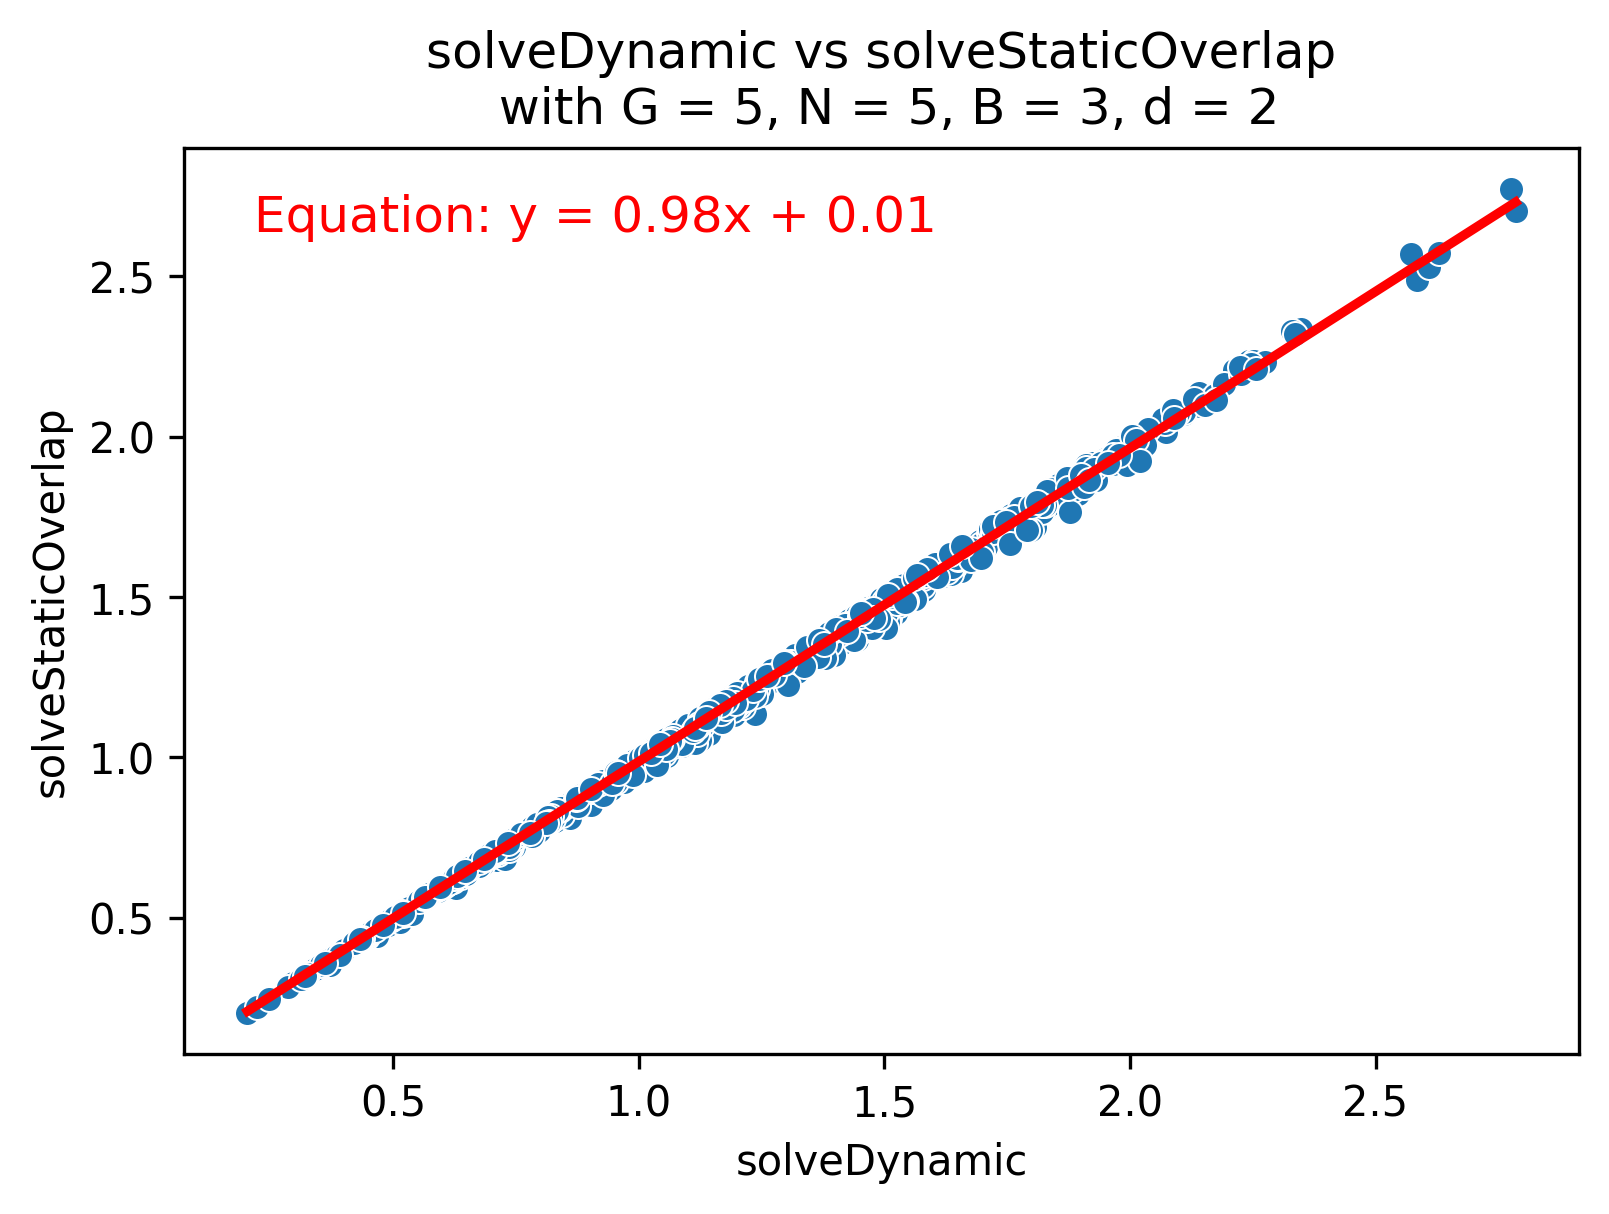

Loading data from data/data_N5_d2_B3_G5.csv
Saved plot as figures/solveStaticOverlap_solveStaticNonOverlap_N5_B3.png


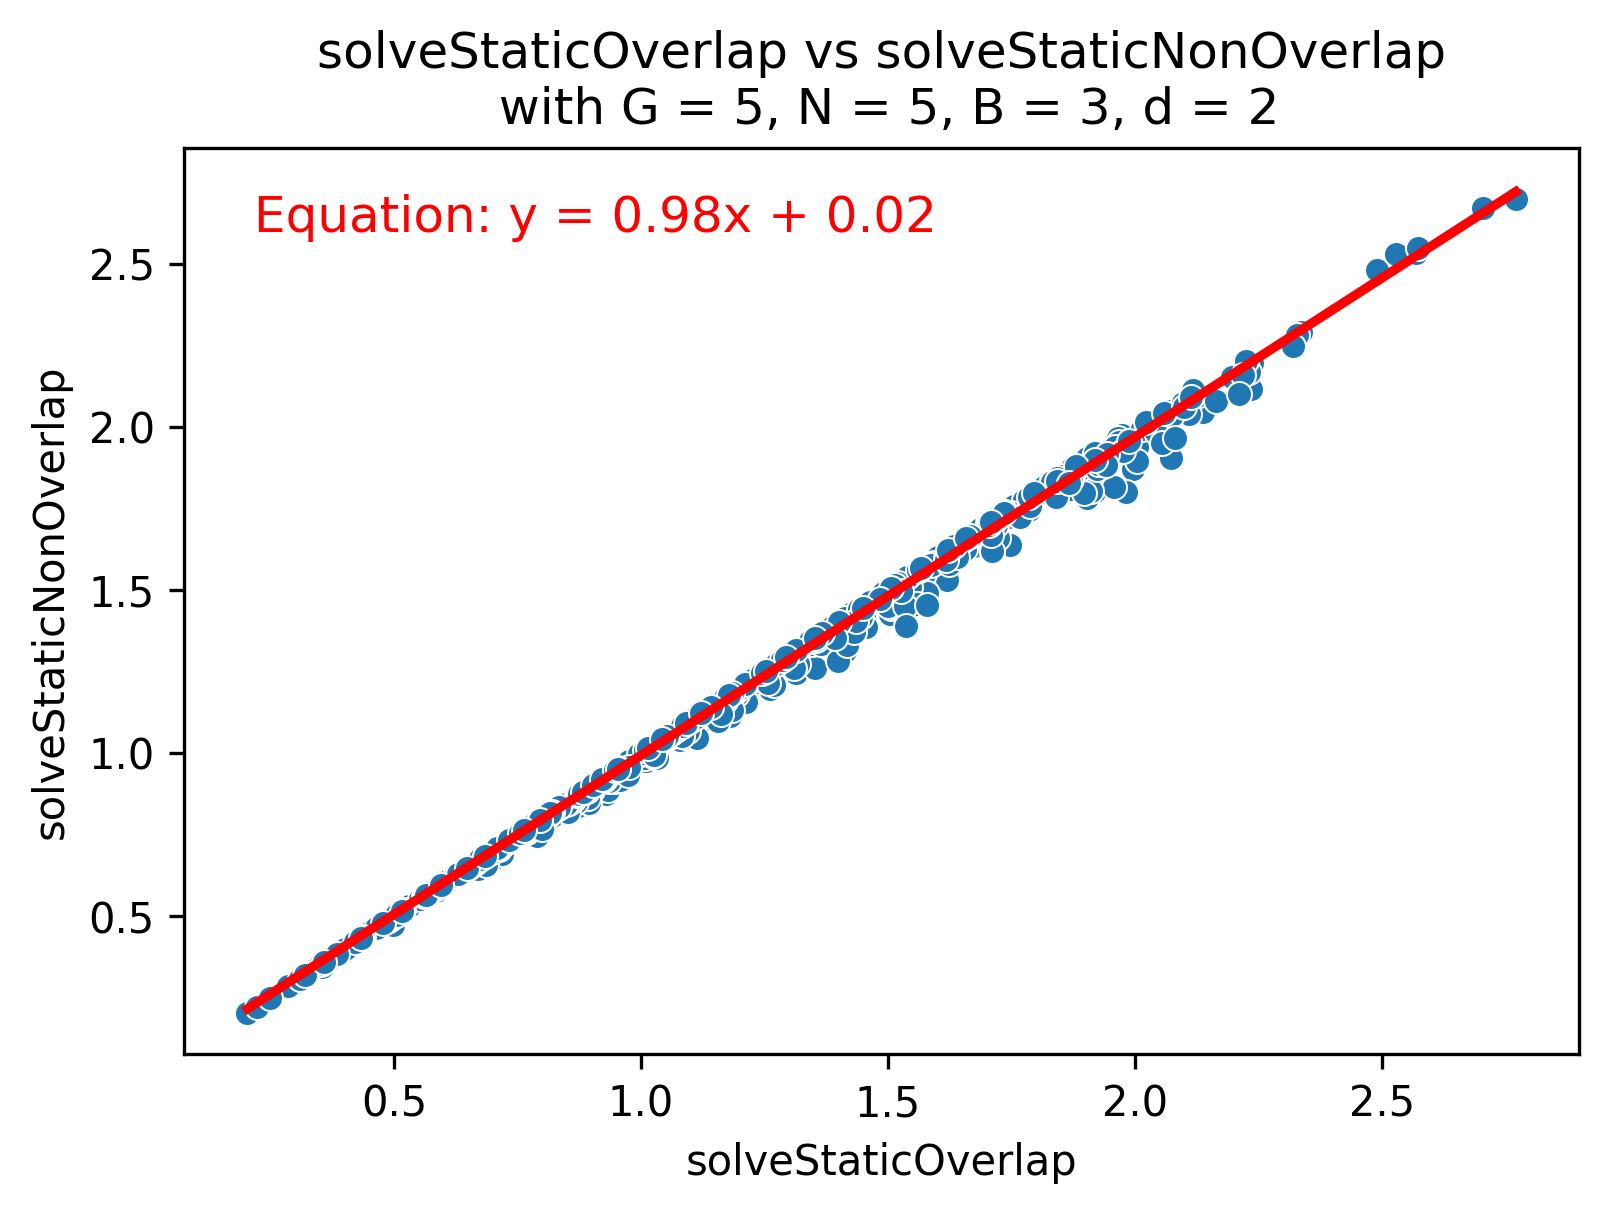

Loading data from data/data_N5_d2_B3_G5.csv
Saved plot as figures/solveStaticNonOverlap_solveStaticNoPool_N5_B3.png


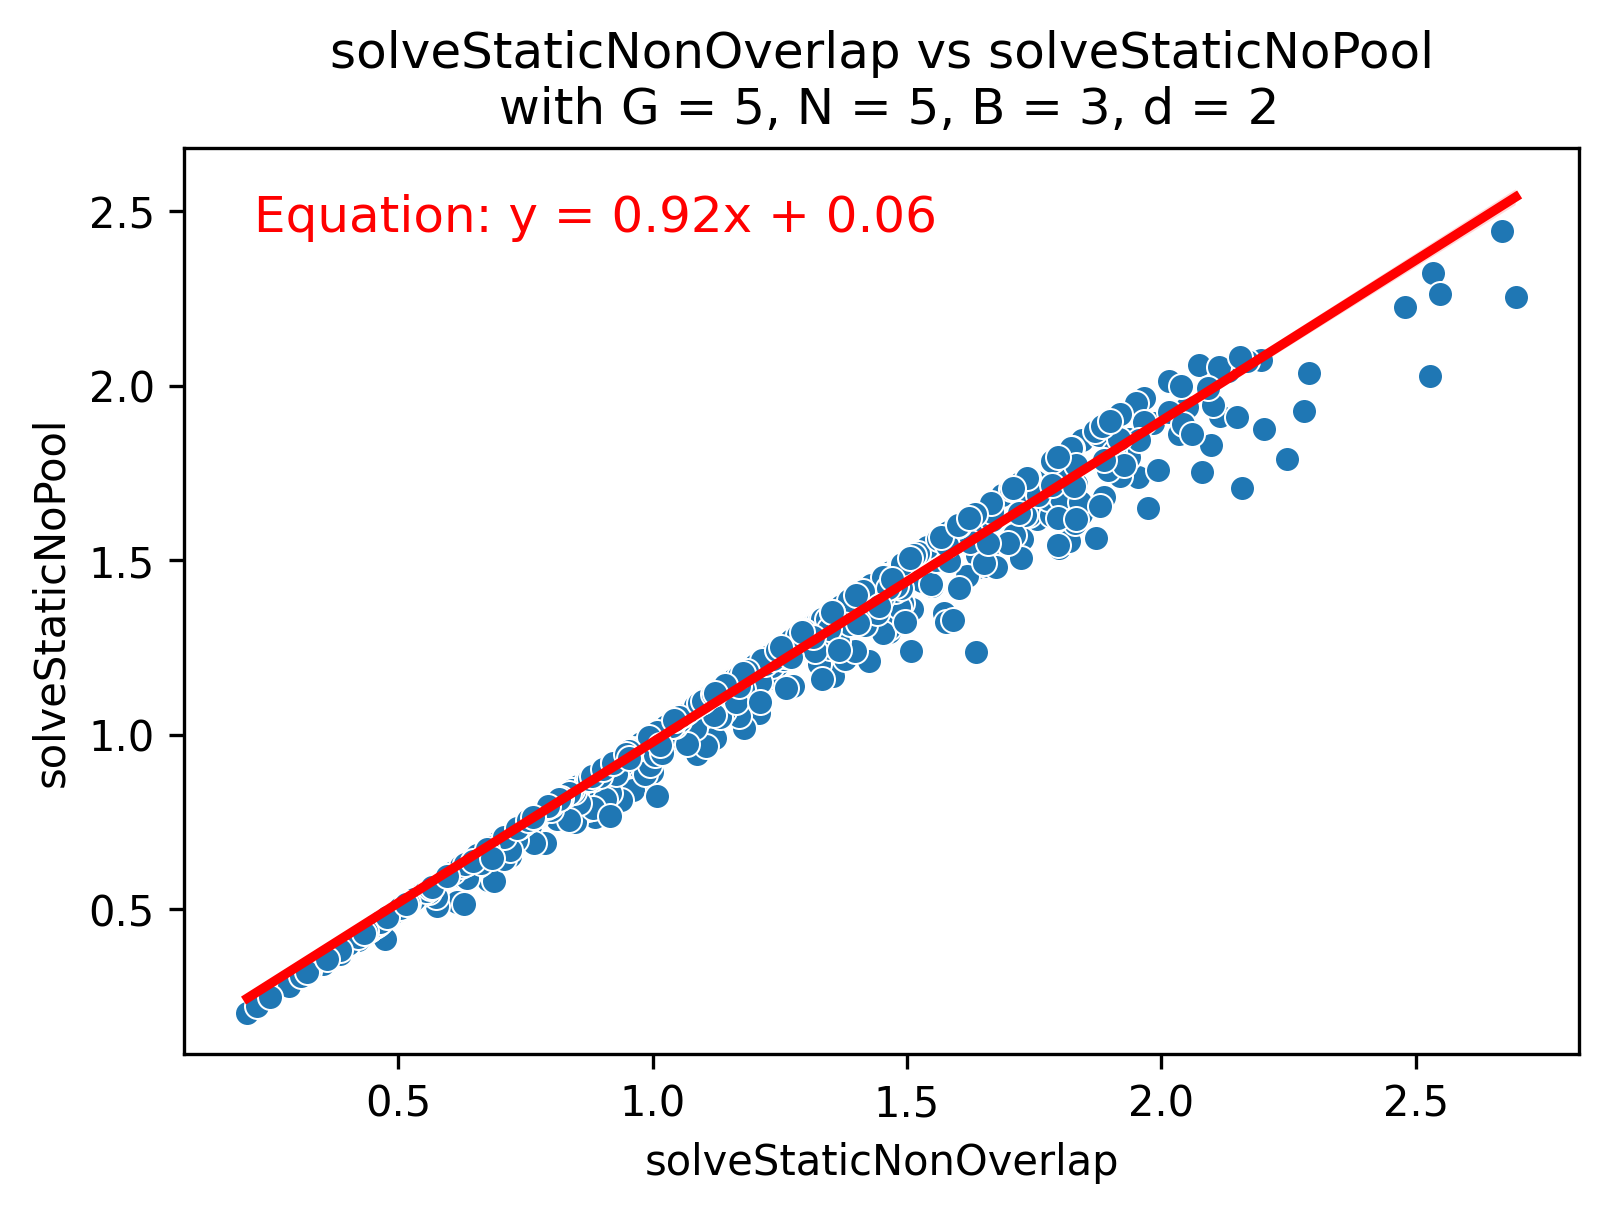

Loading data from data/data_N5_d2_B3_G5.csv
Saved plot as figures/solveDynamic_maxUtil_N5_B3.png


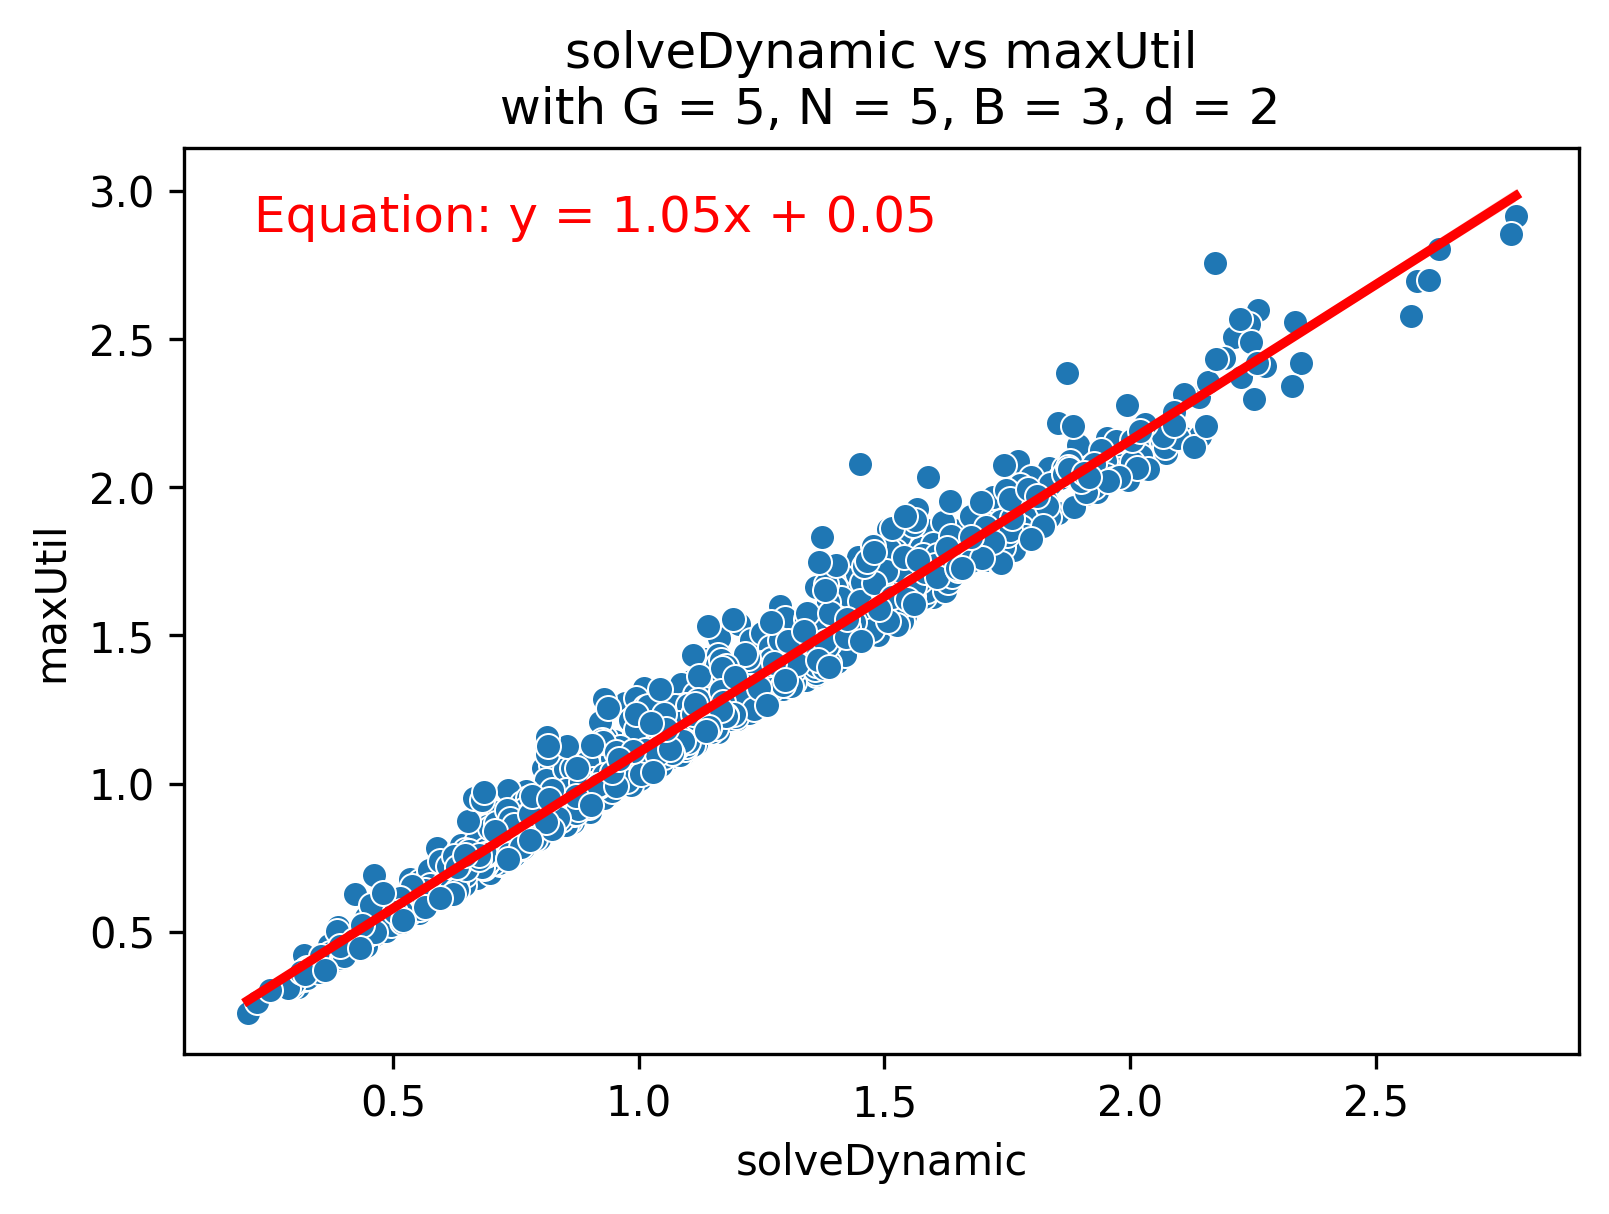

Loading data from data/data_N5_d2_B3_G5.csv
Saved plot as figures/solveDynamic_solveGreedyDynamic_N5_B3.png


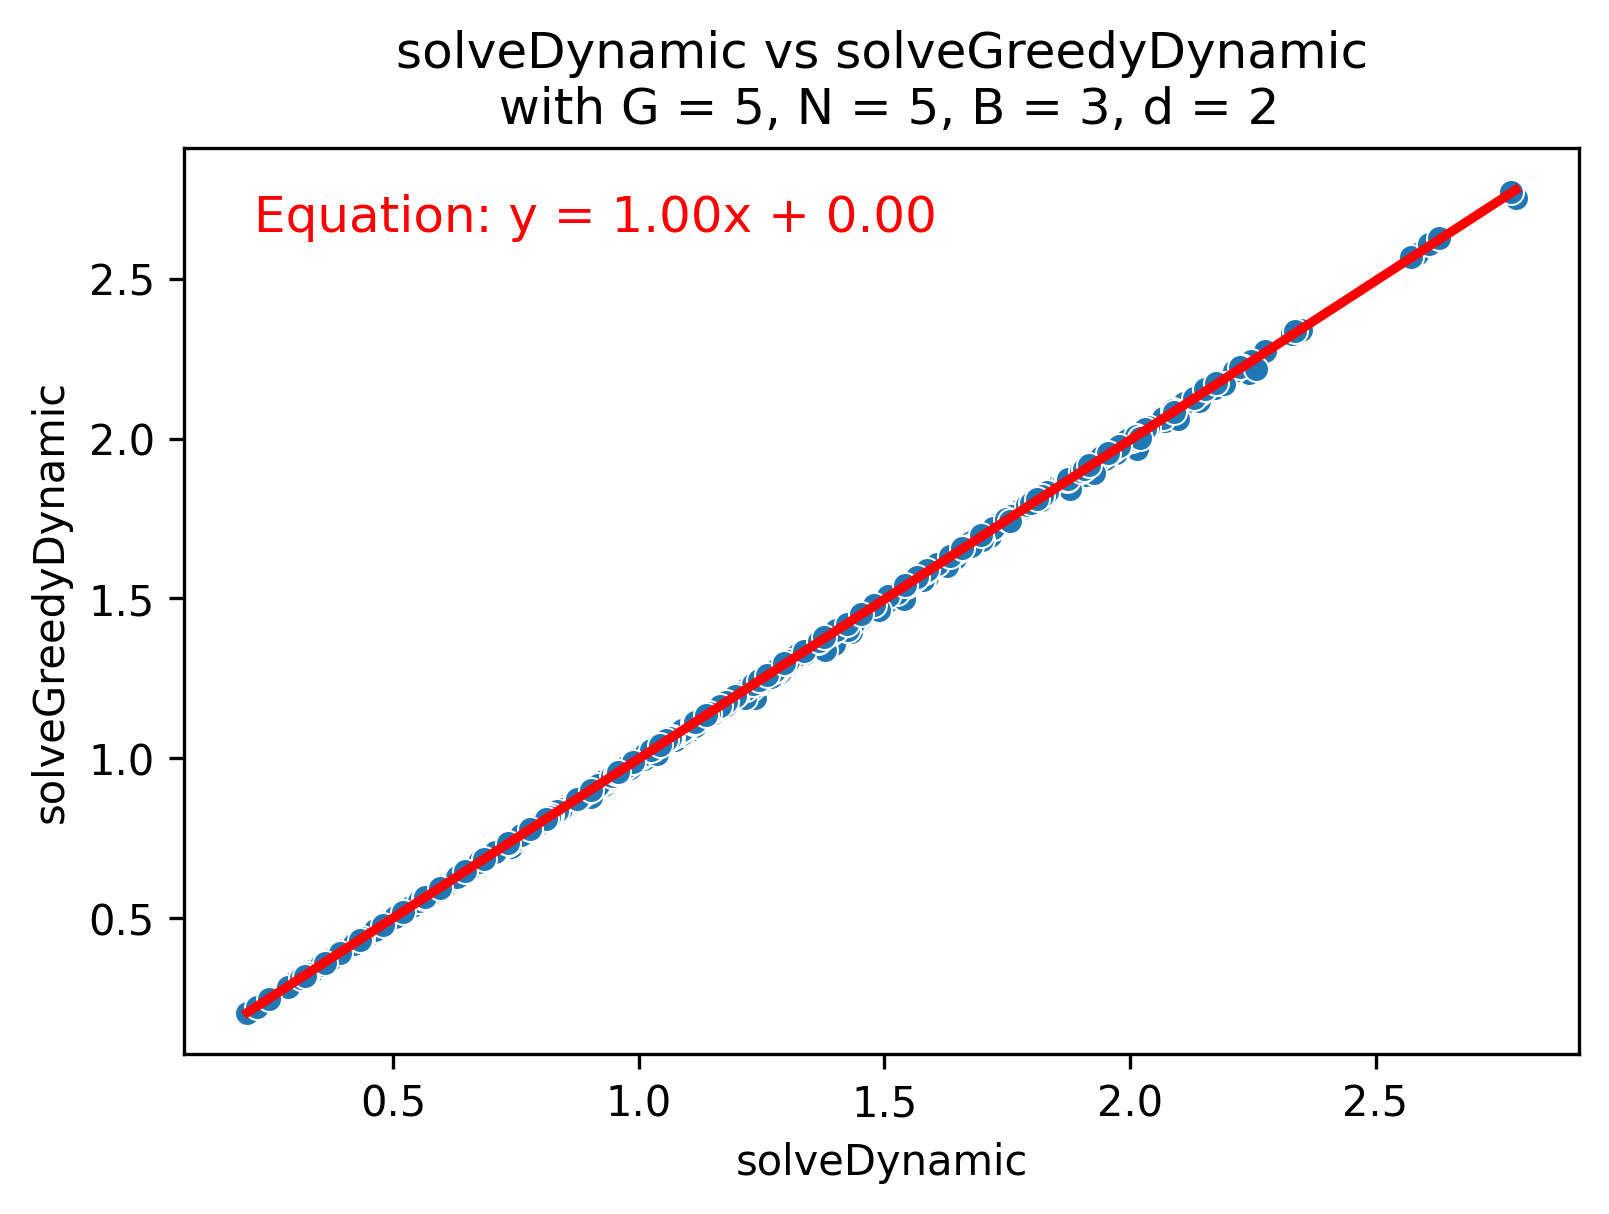

Loading data from data/data_N3_d2_B2_G3.csv
Saved plot as figures/solveDynamic_solveStaticOverlap_N3_B2.png


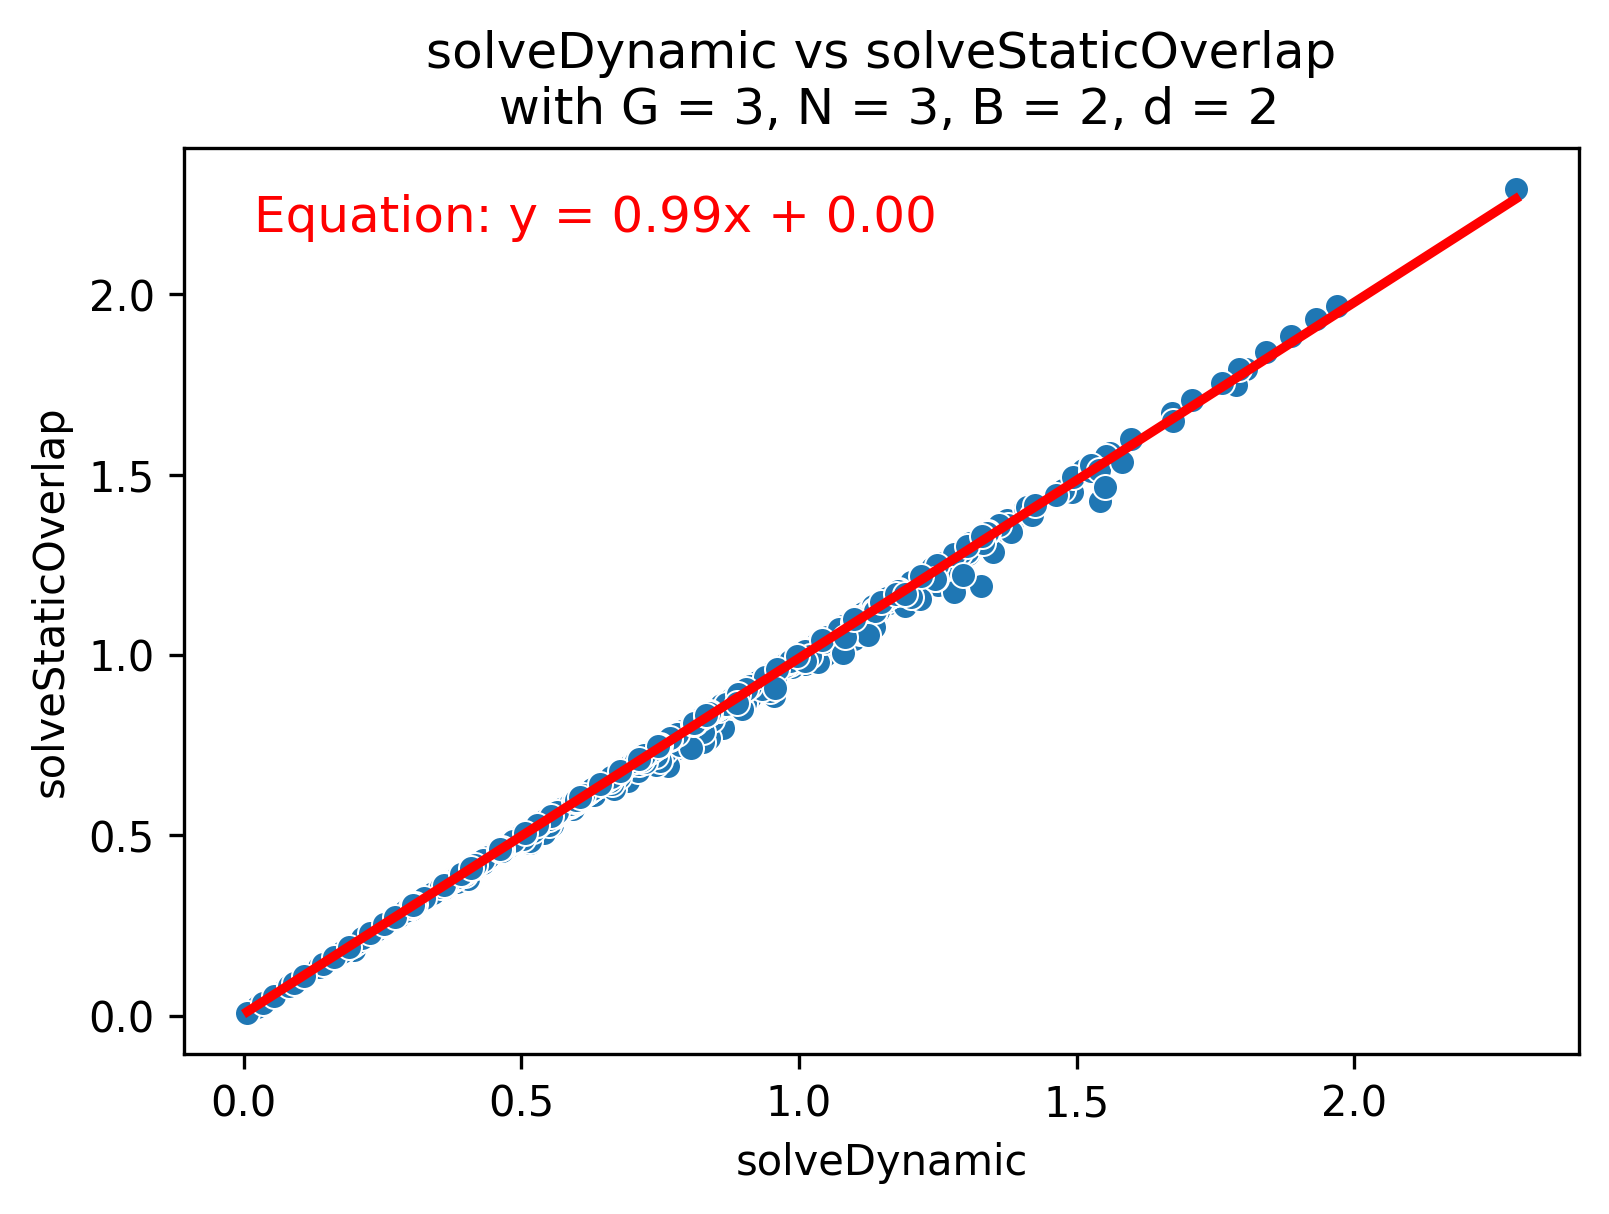

Loading data from data/data_N3_d2_B2_G3.csv
Saved plot as figures/solveStaticOverlap_solveStaticNonOverlap_N3_B2.png


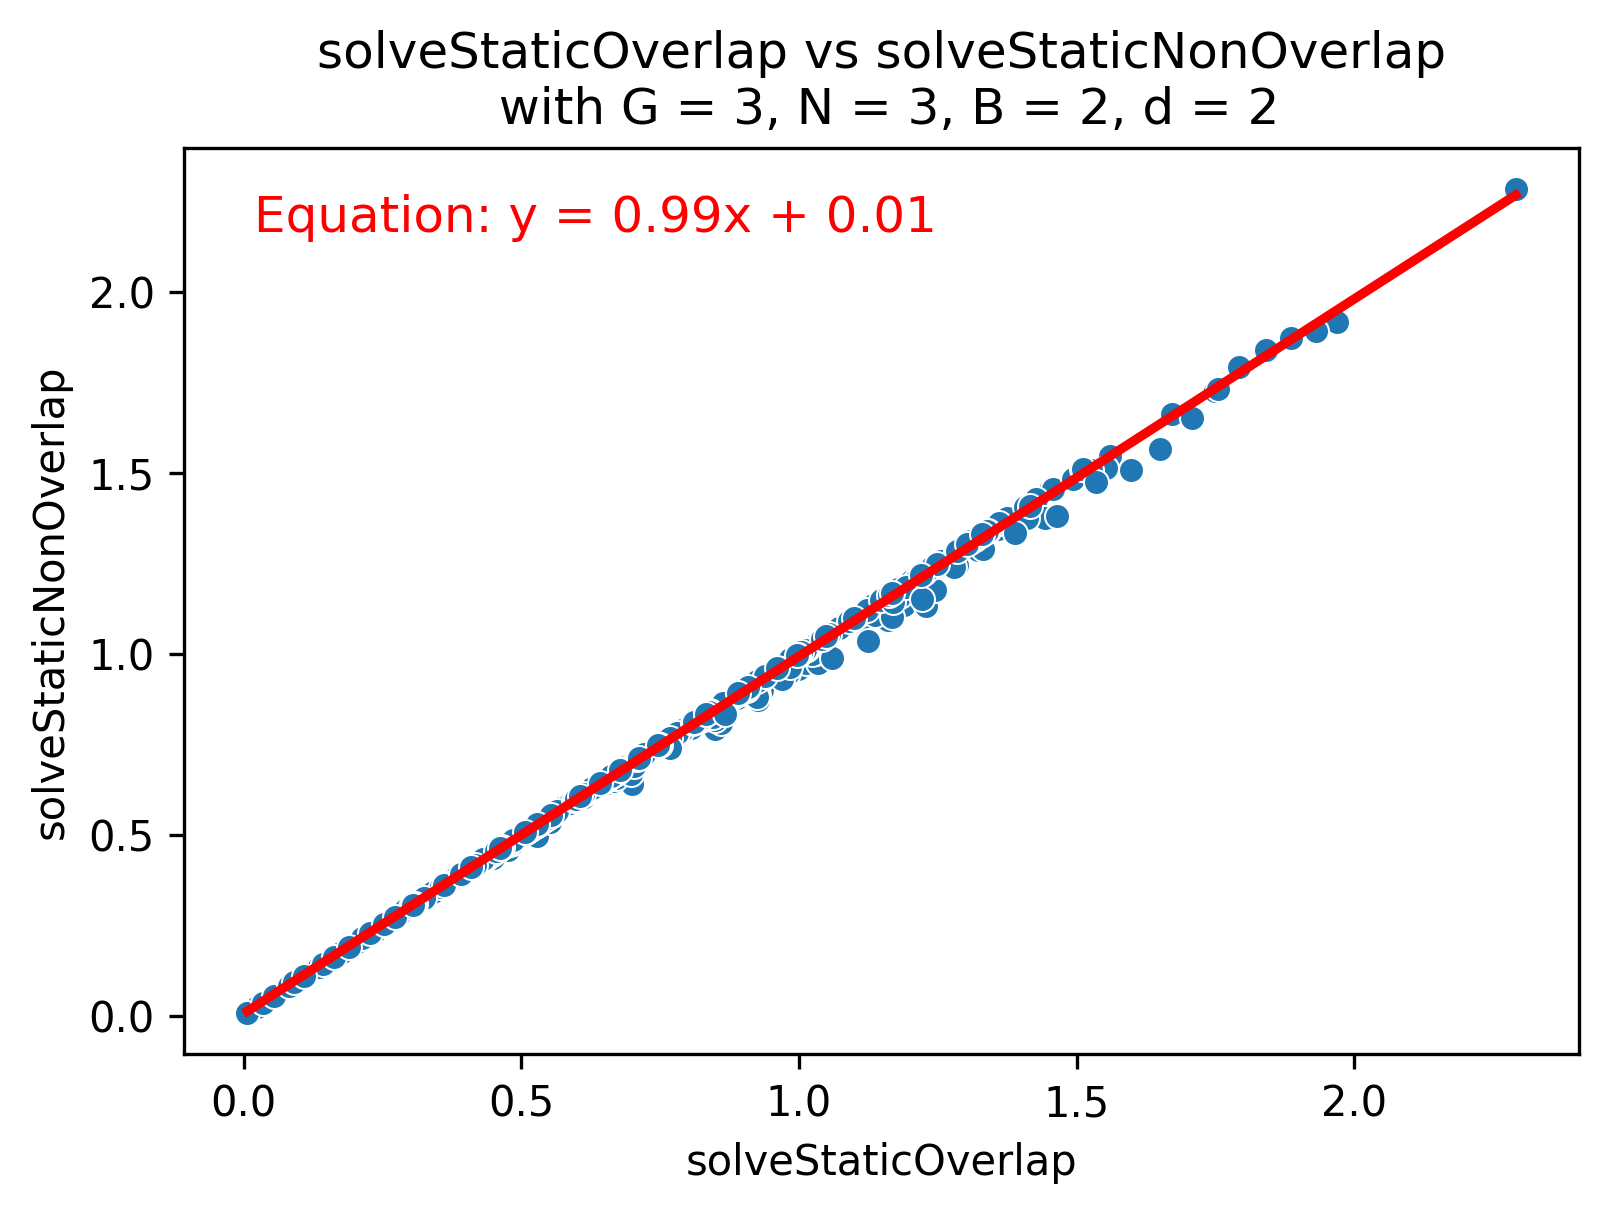

Loading data from data/data_N3_d2_B2_G3.csv
Saved plot as figures/solveStaticNonOverlap_solveStaticNoPool_N3_B2.png


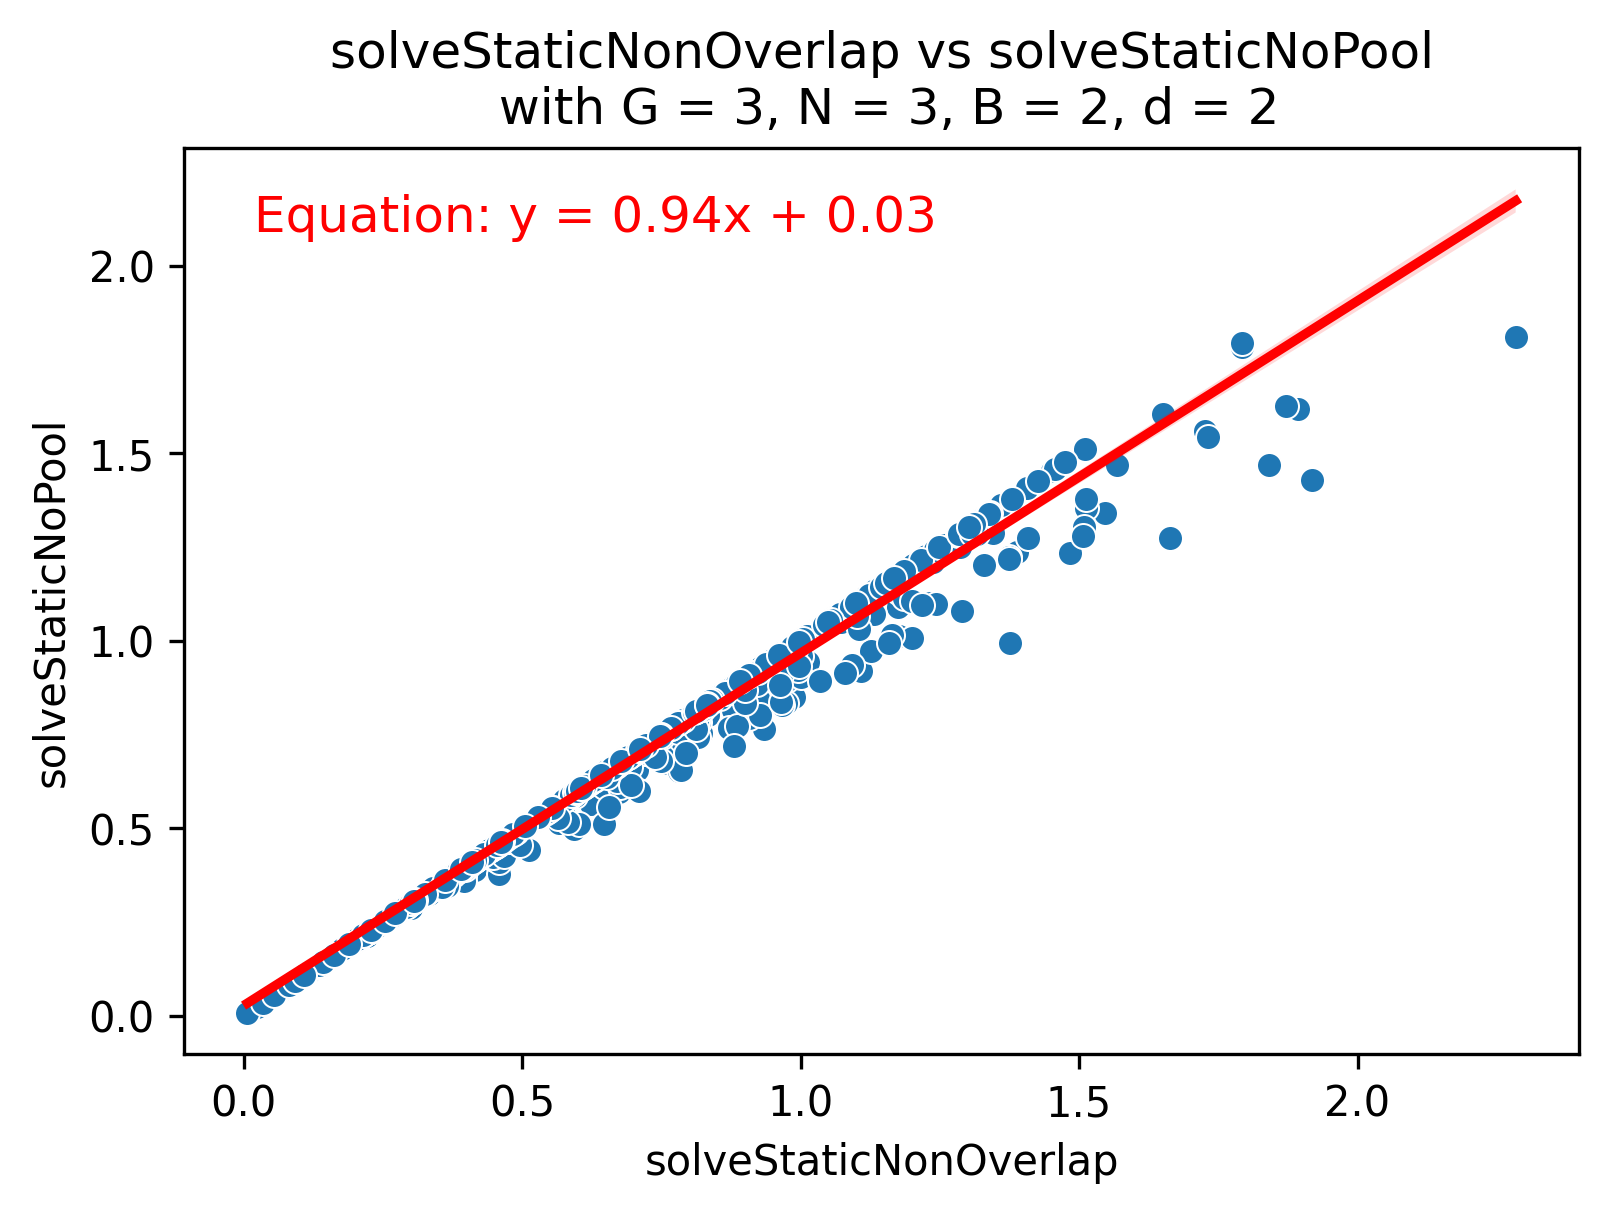

Loading data from data/data_N3_d2_B2_G3.csv
Saved plot as figures/solveDynamic_maxUtil_N3_B2.png


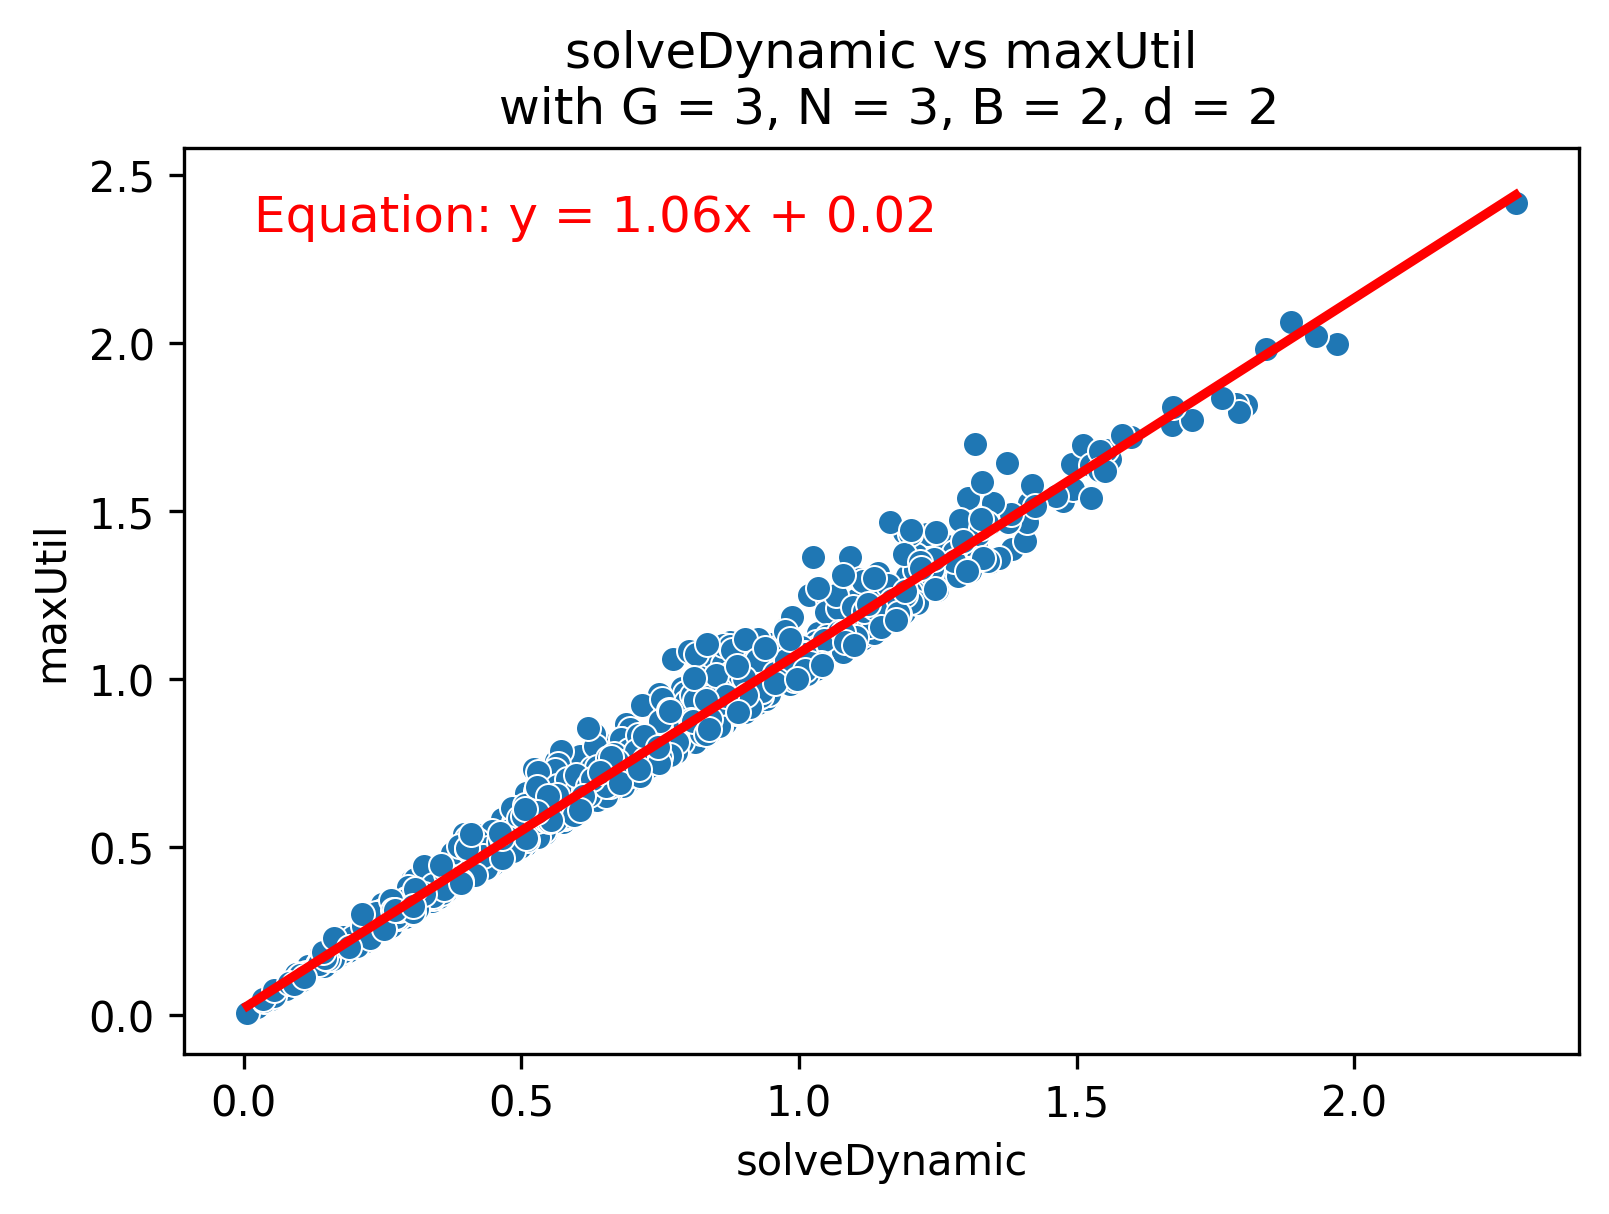

Loading data from data/data_N3_d2_B2_G3.csv
Saved plot as figures/solveDynamic_solveGreedyDynamic_N3_B2.png


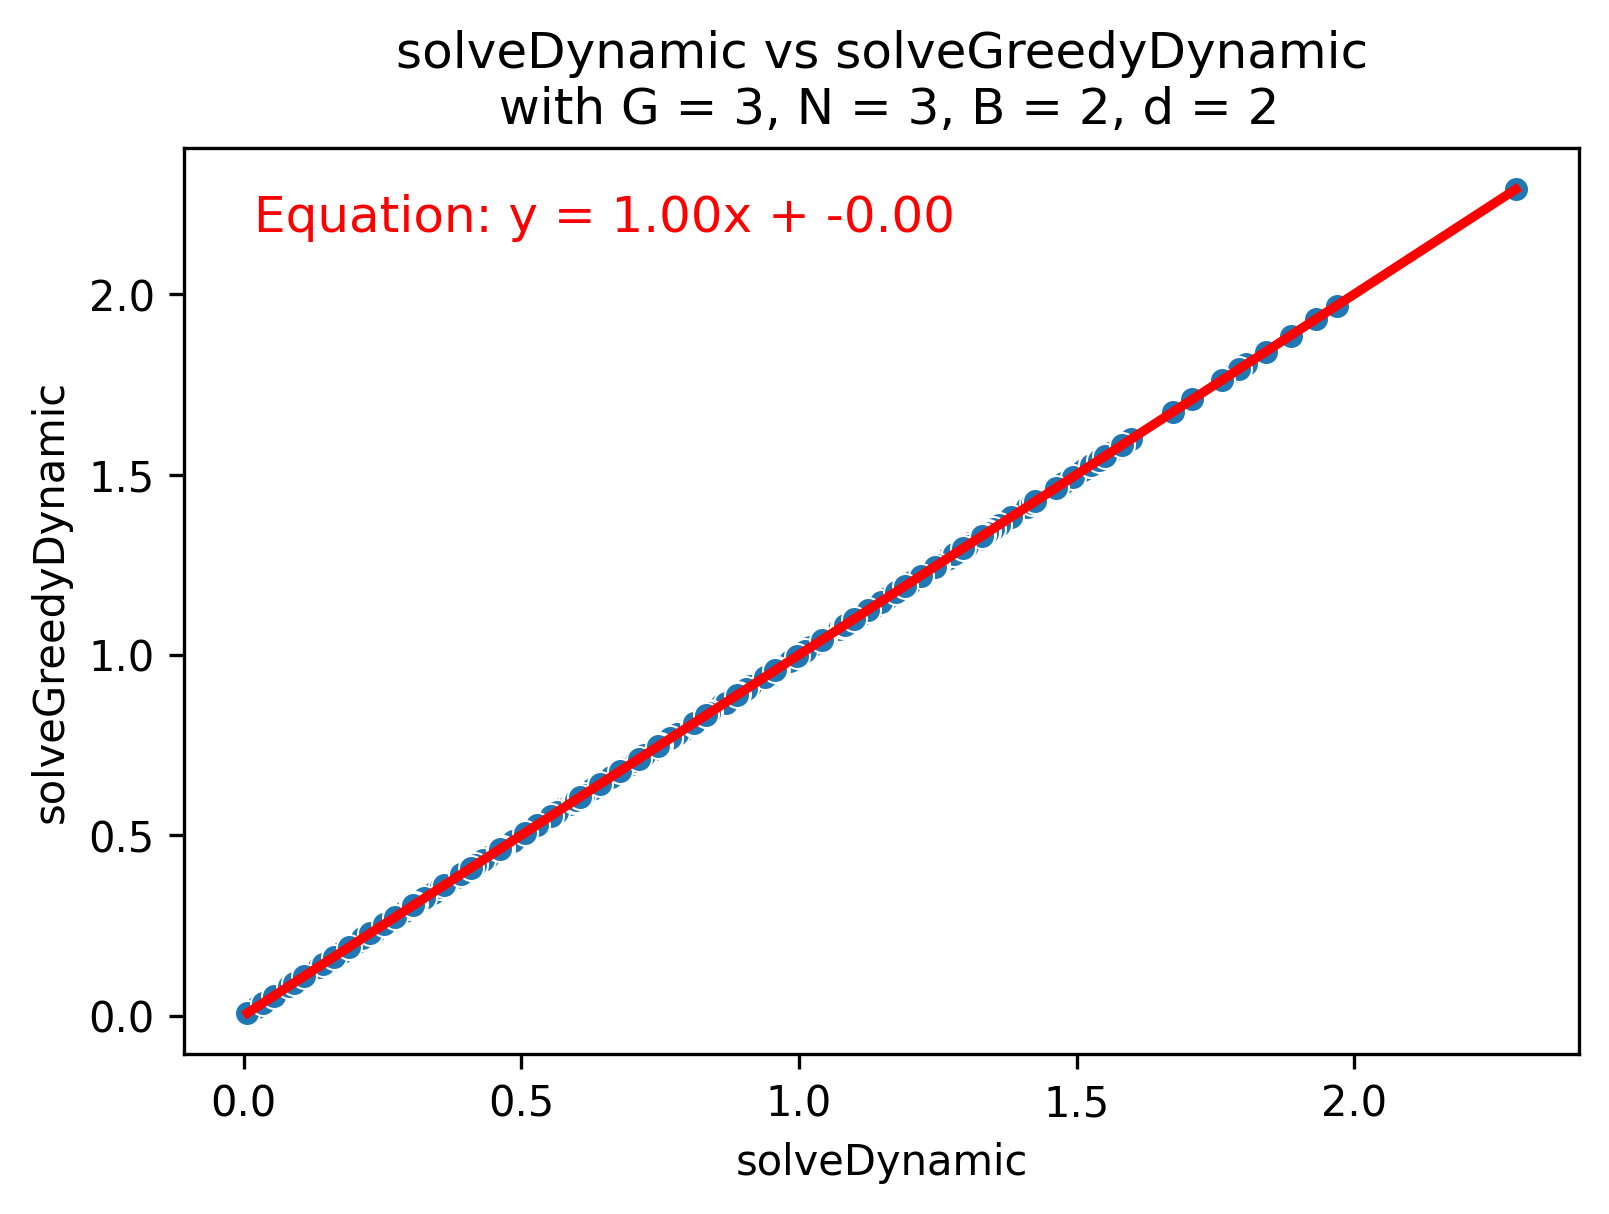

In [72]:
def plot_results(x_func, y_func, combo):
    N = combo['N']
    d = combo['d']
    B = combo['B']
    G = combo['G']
    
    # Create the filename based on the provided combination and functions
    filename = create_filename(N, d, B, G)
    
    # Load the DataFrame from the CSV file
    if os.path.exists(filename):
        print(f"Loading data from {filename}")
        df = pd.read_csv(filename)
    else:
        print(f"No data found for N={N}, d={d}, B={B}, G={G}. Please generate the data first.")
        return
    
    # Scatter plot with line of best fit
    sns.scatterplot(x=df[x_func.__name__], y=df[y_func.__name__])
    
    # Fit the line
    sns.regplot(x=df[x_func.__name__], y=df[y_func.__name__], scatter=False, color="red")
    
    # Linear regression to get the equation of the line
    model = LinearRegression()
    model.fit(df[[x_func.__name__]], df[y_func.__name__])
    slope = model.coef_[0]
    intercept = model.intercept_

    # Add labels, title, and equation
    plt.xlabel(x_func.__name__)
    plt.ylabel(y_func.__name__)
    plt.title(f'{x_func.__name__} vs {y_func.__name__}\n with G = {G}, N = {N}, B = {B}, d = {d}')
    plt.text(
        0.05, 0.95,
        f'Equation: y = {slope:.2f}x + {intercept:.2f}',
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        color='red'
    )
    
    # Save the plot with the desired filename format
    save_filename = f"figures/{x_func.__name__}_{y_func.__name__}_N{N}_B{B}.png"
    plt.savefig(save_filename)
    print(f"Saved plot as {save_filename}")
    
    # Show plot
    plt.show()

# Example combos to test the plotting function
combos = [{'N': 5, 'd': 2, 'B': 3, 'G': 5}, {'N': 3, 'd': 2, 'B': 2, 'G': 3}]
for combo in combos:
    plot_results(solveDynamic, solveStaticOverlap, combo)
    plot_results(solveStaticOverlap, solveStaticNonOverlap, combo)
    plot_results(solveStaticNonOverlap, solveStaticNoPool, combo)
    plot_results(solveDynamic, maxUtil, combo)
    plot_results(solveDynamic, solveGreedyDynamic, combo)

### Agent Types

In [ ]:
def create_types(N, U, Q):
  agents = list()

  for i in range(len(N)):
    for j in range(N[i]):
      agents.append((f"Type {i}, User {j}", U[i], Q[i]))
  return agents

#### Custom Type Testing

In [ ]:
N = [5, 5]
U = [1, 1]
Q = [1/3, 1/2]

G = sum(N)
B = 2

agents = create_types(N, U, Q)

In [ ]:
staticStrategy, staticUtility = solveStaticOverlap(agents, G, B)
dynamicStrategy, dynamicUtility = solveDynamic(agents, G, B)

KeyboardInterrupt: 

In [ ]:
print(f"Ratio: {dynamicUtility/staticUtility}")
printDynamic(dynamicStrategy, dynamicUtility)
printStatic(staticStrategy, staticUtility)

## Appendix

### Old Dif. Ev. Code

In [ ]:
# greedy dynamic vs. dynamic

# Define your objective function (the 'ratio' function)
def ratio(x):
  agents = [(0, x[0], x[1]), (1, x[2], x[3]), (2, x[4], x[5])]
  return -solveDynamic(agents)[1]/solveGreedyDynamic(agents)[1]

# Define the bounds for each input variable (assuming they are all between 0 and 1)
bounds = [(0, 1)] * 6

# Run global optimization using differential evolution
result = differential_evolution(ratio, bounds)

# Retrieve the optimal solution
optimal_solution = result.x
optimal_value = result.fun

agents = [(0, optimal_solution[0], optimal_solution[1]), (1, optimal_solution[2], optimal_solution[3]), (2, optimal_solution[4], optimal_solution[5])]
greedyDynamicStrategy, greedyDynamicUtility = solveGreedyDynamic(agents)
dynamicStrategy, dynamicUtility = solveDynamic(agents)
maxUtility = maxUtil(agents)
print(f"We have agents {agents}.")
printDynamic(dynamicStrategy, dynamicUtility)
printDynamic(greedyDynamicStrategy, greedyDynamicUtility, greedy=True)
print(f"\nRatio: {dynamicUtility/greedyDynamicUtility}")
print(f"\nMaximum Utility: {maxUtility}")

### Incorrect Use of Bayes' Theorem

In [ ]:
def bayesTheorem(agents, posGroups, negAgents):

  posGroups = list(posGroups)
  posGroups = sorted(posGroups, key=len)

  newAgents = []

  for agent in agents:
    if agent[0] in set(negAgents):
      newAgents.append((agent[0], 0, 1))
    else:
      newAgents.append(agent)

  agentDict = {}
  for agent in newAgents:
    agentDict[agent[0]] = (agent[1], agent[2])

  def genSubsets(posGroups):
    subsets = []
    for i in range(1, 2**len(posGroups)):
      subset = [posGroups[j] for j in range(len(posGroups)) if (i >> j) & 1]
      subsets.append(subset)

    return subsets

  subsets = genSubsets(posGroups)

  probIntersectPos = {}

  for subset in subsets:

    healthy = 1

    intersect = list(set.intersection(*[set(s) for s in subset]))

    for person in intersect:
      healthy *= agentDict[person][1]

    probIntersectPos[tuple(subset)] = 1 - healthy

  probPos = {}
  probPos[tuple(posGroups)] = 0 if len(subsets) > 0 else 1
  for subset in subsets:
    if len(subset) % 2 == 0:
      probPos[tuple(posGroups)] -= probIntersectPos[tuple(subset)]
    else:
      probPos[tuple(posGroups)] += probIntersectPos[tuple(subset)]

  # finalAgents = []

  for agent in newAgents:

    # P(agent is Pos | posGroups) = P(posGroups | agent is Pos) * P(agent in Pos) / P(posGroups)
    # = P(pos Groups agent not in) * P(agent is Pos) / P(posGroups)

    if agent[2] == 1 or agent[2] == 0:
      # finalAgents.append(agent)
      agentDict[agent[0]] = (agent[1], agent[2])
    else:

      posNotIn = [posGroup for posGroup in posGroups if agent[0] not in posGroup]

      if tuple(posNotIn) not in probPos:

        subsets = genSubsets(posNotIn)
        probPos[tuple(posNotIn)] = 0 if len(subsets) > 0 else 1
        for subset in subsets:
          if len(subset) % 2 == 0:
            probPos[tuple(posNotIn)] -= probIntersectPos[tuple(subset)]
          else:
            probPos[tuple(posNotIn)] += probIntersectPos[tuple(subset)]

      pAgentPos = probPos[tuple(posNotIn)] * (1 - agent[2]) / probPos[tuple(posGroups)]
      health = 1 - pAgentPos

      # finalAgents.append((agent[0], agent[1], health))
      agentDict[agent[0]] = (agent[1], health)

  # for agent in finalAgents:
  #   agentDict[agent[0]] = (agent[1], agent[2])

  return agentDict

### Using Dictionaries for Agents

In [ ]:
# dictionary of (utility, probability of healthy) dictionaries with ID as key

def create_agents(n = n):
  agents = dict()

  for id in range(n):
    agents[id] = {"utility" : random.random(), "healthy" : random.random()}
  return agents

agents = create_agents()

print(agents)

In [ ]:
def maxUtil(agents):
  util = 0
  for id in agents:
    util += agents[id]['utility'] * agents[id]['healthy']
  return util

In [ ]:
def solveStaticNoPool(agents, B=B):
  utils = []
  for id in agents:
    utils.append(agents[id]['utility'] * agents[id]['healthy'])
  utils = sorted(utils, reverse=True)
    # Take the first B elements and sum them
  util = sum(utils[:B])
  return util

In [ ]:
def solveStaticNonOverlap(agents, G = G, B = B):

  def generate_non_overlapping_subsets(agents, G, B):
    # Generate all possible subsets of agents with sizes up to G
    subsets = []
    for r in range(1, G+1):
        subsets.extend(combinations(agents, r))

    # Generate combinations of B non-overlapping subsets
    combos = combinations(subsets, B)

    # Filter combinations to keep only non-overlapping ones
    non_overlapping_combinations = []
    for combination in combos:
        combined_set = set()
        is_non_overlapping = True
        for subset in combination:
            if combined_set.intersection(subset):
                is_non_overlapping = False
                break
            combined_set.update(subset)
        if is_non_overlapping:
            non_overlapping_combinations.append(combination)

    return non_overlapping_combinations

  def strategyUtilitySNO(combination):
    utility = 0
    for group in combination:
      groupUtility = 0
      groupHealthy = 1
      for id in group:
        groupUtility += agents[id]['utility']
        groupHealthy *= agents[id]['healthy']
      utility += groupHealthy * groupUtility
    return utility

  strategy = dict()
  combos = generate_non_overlapping_subsets(agents, G, B)
  for combination in combos:
    strategy[combination] = strategyUtilitySNO(combination)
  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

### Alternate Print for Dynamic

In [ ]:
def printDynamic(strategy, utility = 0):
  if utility > 0:
    print(f"\nDynamic Strategy, Utility {utility}:")
  for i in range(math.floor(len(strategy)/3)):
    print(f"Test {i * 3 + 1}: {strategy[i]}")
    if strategy[i+1]:
      print(f"If positive, test {strategy[i+1]}")
    if strategy[i+2]:
      print(f"If negative, test {strategy[i+2]}")

### Solve Static Overlap by Enumeration

In [ ]:
def solveStaticOverlap(agents, G = G, B = B):

  def generate_overlapping_subsets(agents, G, B):

    # Generate all possible subsets of agents with sizes up to G
    subsets = []
    for r in range(1, G+1):
        subsets.extend(combinations(agents, r))

    # Generate combinations of B subsets without enforcing overlap
    combos = combinations(subsets, B)
    return combos

  def strategyUtilitySO(combination):
    utility = 0

    for instance in list(product([0, 1], repeat=len(agents))):

      likelihood = 1
      for i in range(len(agents)):
        likelihood *= agents[i][2] * instance[i] + (1 - agents[i][2]) * (1 - instance[i])

      safeAgents = set()
      for group in combination:
        safe = True
        for agent in group:
          if instance[agent[0]] == 0:
            safe = False
        if safe:
          safeAgents.update(group)

      for agent in list(safeAgents):
        utility += likelihood * agent[1]

    return utility

  strategy = dict()
  combos = generate_overlapping_subsets(agents, G, B)
  for combination in combos:
    strategy[combination] = strategyUtilitySO(combination)
  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

### Solve Static: Does Not Update Priors After a Positive Test for those not in Test

In [ ]:
def solveStaticOverlap(agents, G = G, B = B, posGroups = frozenset()):

  def generate_overlapping_subsets(agents, G, B):

    # Generate all possible subsets of agents with sizes up to G
    subsets = []
    for r in range(1, G+1):
        subsets.extend(combinations(agents, r))

    # Generate combinations of B subsets without enforcing overlap
    combos = combinations(subsets, B)
    return combos

  def groupHelp(group, posGroups = frozenset()):

    groupIDs = frozenset({person[0] for person in group})
    groupUtility = 0
    groupHealthy = 1
    for posGroup in posGroups:
      if posGroup.issubset(groupIDs):
        groupHealthy = 0

    for person in group:
      groupUtility += person[1]
      groupHealthy *= person[2]

    groupUtility *= groupHealthy
    return groupHealthy, groupUtility


  def strategyUtility(combination, posGroups = frozenset()):
    utility = 0

    if len(combination) > 0:

      firstGroup = combination[0]
      groupIDs = frozenset({person[0] for person in firstGroup})

      firstHealthy, firstUtility = groupHelp(firstGroup, posGroups, negAgents)
      utility += firstUtility

      # positive test
      if firstHealthy < 1:
        posScenario = []
        for group in combination[1:]:
          updatedGroup = []
          for person in group:
            if person in firstGroup:
              updatedGroup.append((person[0], person[1], 1 - (1-person[2])/(1-firstHealthy)))
            else:
              updatedGroup.append(person)
          posScenario.append(updatedGroup)

        newPosGroups = posGroups.copy()
        set(newPosGroups).add(groupIDs)

        utility += strategyUtility(posScenario, newPosGroups) * (1-firstHealthy)

      # negative test
      if firstHealthy > 0:
        negScenario = []
        for group in combination[1:]:
          updatedGroup = []
          for person in group:
            if person in firstGroup:
              updatedGroup.append((person[0], 0, 1))
            else:
              updatedGroup.append(person)
          negScenario.append(updatedGroup)

        newPosGroups = set()
        for posGroup in posGroups:
          newPosGroups.add(posGroup.difference(groupIDs))
        for posGroup in posGroups:
          groupHealthy = 1
          for person in posGroup:
            groupHealthy *= person[2]
          for group in negScenario:
            for agent in group:
              for person in posGroup:
                if person[0] == agent[0]:
                  group.remove(agent)
                  group.append(person[0], person[1], 1 - (1-person[2])/(1-groupHealthy))

        utility += strategyUtility(negScenario, frozenset(newPosGroups)) * firstHealthy

    return utility

  strategy = dict()
  combos = generate_overlapping_subsets(agents, G, B)
  for combination in combos:
    strategy[combination] = strategyUtility(combination)
  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

### Solve Dynamic: Does Not Update Priors After a Positive Test for those not in Test

In [ ]:
def solveDynamic(agents, G = G, B = B, posGroups = frozenset()):

  if B == 0:
    return [], 0

  def generate_subsets(agents, G=G):
      subsets = []
      for r in range(1, G + 1):
          subsets.extend(combinations(agents, r))
      return subsets

  strategy = dict()
  combos = generate_subsets(agents, G)
  for combination in combos:
    utility = 0

    # first test
    firstTest = combination
    firstUtility = 0
    firstHealthy = 1

    # remaining users
    remaining = [person for person in agents if person not in firstTest]

    # utility, P(Healthy) of first test
    firstIDs = frozenset({person[0] for person in firstTest})
    if posGroups:
      for posGroup in posGroups:
        if posGroup.issubset(firstIDs):
          firstHealthy = 0
    else:
      posGroups = frozenset()

    for person in firstTest:
      firstUtility += person[1]
      firstHealthy *= person[2]
    utility += firstUtility * firstHealthy

    # positive scenario
    posScenario = []
    if firstHealthy < 1:
      for person in firstTest:
          posScenario.append((person[0], person[1], 1 - (1-person[2])/(1-firstHealthy)))

      newPosGroups = posGroups.copy()
      set(newPosGroups).add(firstIDs)
      posStrategy, posUtility = solveDynamic(posScenario + remaining, G, B-1, frozenset(newPosGroups))

      utility += (1- firstHealthy) * posUtility
    else:
      posStrategy = []

    # negative scenario
    if remaining and firstHealthy > 0:
      newPosGroups = set()
      for posGroup in posGroups:
        newPosGroups.append(posGroup.difference(firstIDs))
      for posGroup in posGroups:
        groupHealthy = 1
        for person in posGroup:
          groupHealthy *= person[2]
        for agent in remaining:
          for person in posGroup:
            if person[0] == agent[0]:
              remaining.remove(agent)
              remaining.append(person[0], person[1], 1 - (1-person[2])/(1-groupHealthy))

      negStrategy, negUtility = solveDynamic(remaining, G, B-1, frozenset(newPosGroups))
      utility += firstHealthy * negUtility
    else:
      negStrategy = []

    strategy[(tuple(firstTest), tuple(posStrategy), tuple(negStrategy))] = utility

  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

### Dynamic Overlapping for $B=2$

In [ ]:
def solveDynamicB2(agents, G = G):

  def generate_subsets(Agents, G=G):
      subsets = []
      for r in range(1, G + 1):
          subsets.extend(combinations(Agents, r))
      return subsets

  def generate_contained_subsets(Agents, G=G):
      subsets = generate_subsets(Agents, G)
      contained_subsets = []

      for x in subsets:
          for y in subsets:
              if x != y and not set(x).issubset(y) and len(set(x).intersection(y)) > 0:
                  contained_subsets.append((x, y))

      return contained_subsets

  strategy = dict()
  combos = generate_contained_subsets(agents, G)
  for combination in combos:
    utility = 0

    # first test
    firstTest = combination[0]
    firstUtility = 0
    firstHealthy = 1

    for person in firstTest:
      firstUtility += person[1]
      firstHealthy *= person[2]
    utility += firstUtility * firstHealthy

    # positive scenario
    pos = []
    if firstHealthy < 1:
      for person in combination[1]:
        if person in firstTest:
          pos.append((person[0], person[1], 1 - (1-person[2])/(1-firstHealthy)))
        else:
          pos.append(person)

      secondUtility = 0
      secondHealthy = 1
      for person in pos:
        secondUtility += person[1]
        secondHealthy *= person[2]

      utility += (1- firstHealthy) * secondUtility * secondHealthy

    # negative scenario
    remaining = [person for person in agents if person not in firstTest]
    if remaining:
      neg, value = solveStatic(remaining, G, 1)
      utility += firstHealthy * value

    strategy[(tuple(firstTest), tuple(pos), tuple(neg))] = utility

  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

### Dynamic Allocation where $t_2 ⊆ t_1$

In [ ]:
def solveDynamic(agents, G = G, B1 = 1, B2 = 1):
  strategy = dict()
  combos = generate_non_overlapping_subsets(agents, G, B1)
  for combination in combos:
    utility = 0
    for group in combination:
      groupHealthy = 1
      groupUtility = 0
      for person in group:
        groupUtility += person[1]
        groupHealthy *= person[2]
      # negative scenario
      utility += groupHealthy * groupUtility
      # positive scenario
      substrategy = ()
      if groupHealthy < 1:
        subagents = []
        for person in group:
          subagents.append((person[0], person[1], 1 - (1-person[2])/(1-groupHealthy)))
        substrategy, subutility = solveStatic(subagents, len(subagents), B2)
        utility += (1 - groupHealthy) * subutility
      strategy[(combination, substrategy)] = utility

  optimal = max(strategy, key=strategy.get)
  return optimal, strategy[optimal]

In [ ]:
optimal = solveDynamic(agents)

print(f"First test {optimal[0][0][0]}. If positive, test {optimal[0][1][0]}. This gives expected utility {optimal[1]}.")

### Comparing Non-Overlapping Strategies

Search for a dynamic-optimal strategy:

In [ ]:
dynamicUtility = 0
staticUtility = 0

while staticUtility >= dynamicUtility:
  agents = create_agents()
  staticStrategy, staticUtility = solveStatic(agents)
  dynamicStrategy, dynamicUtility = solveDynamic(agents)

print(agents)
print(dynamicUtility)
print(dynamicStrategy)
print(staticUtility)
print(staticStrategy)

Find the best ratio:

In [ ]:
N = 1000000
bestRatio = 0

for _ in range(N):
  agents = create_agents()
  staticStrategy, staticUtility = solveStatic(agents)
  dynamicStrategy, dynamicUtility = solveDynamic(agents)
  ratio = dynamicUtility / staticUtility
  if ratio > bestRatio:
    bestRatio = ratio
    bestAgents = agents

print(f"A ratio of {bestRatio} has been obtained.")
print(f"We have agents {bestAgents}.")
staticStrategy, staticUtility = solveStatic(bestAgents)
dynamicStrategy, dynamicUtility = solveDynamic(bestAgents)
print(f"The dynamic strategy is to first test {dynamicStrategy[0][0]}. If positive, test {dynamicStrategy[1][0]}. This gives expected utility {dynamicUtility}.")
print(f"The static utility is to test {staticStrategy} for expected utility {staticUtility}")

Testing for $n=5$:

In [ ]:
n = 5
N = 100000
bestRatio = 0

for _ in range(N):
  agents = create_agents(n)
  staticStrategy, staticUtility = solveStatic(agents)
  dynamicStrategy, dynamicUtility = solveDynamic(agents)
  ratio = dynamicUtility / staticUtility
  if ratio > bestRatio:
    bestRatio = ratio
    bestAgents = agents

print(f"A ratio of {bestRatio} has been obtained.")
print(f"We have agents {agents}.")
print(f"The dynamic strategy is to first test {dynamicStrategy[0][0]}. If positive, test {dynamicStrategy[1][0]}. This gives expected utility {dynamicUtility}.")
print(f"The static utility is to test {staticStrategy} for expected utility {staticUtility}")

Grid search:

In [ ]:
n = 3
def ratios(values):
  if 0 in values:
    return 0
  agents = [(0, values[0], values[1]), (1, values[2], values[3]), (2, values[4], values[5])]
  return solveDynamic(agents)[1]/solveStatic(agents)[1]

def iterate_combinations(range_max, step_size):
    num_values = int(range_max / step_size) + 1
    values = [i * step_size for i in range(num_values)]
    combinations = itertools.product(values, repeat=n*2)
    max_value = float('-inf')
    max_combination = None
    for combination in combinations:
        func_value = ratios(combination)
        if func_value > max_value:
            max_value = func_value
            max_combination = combination
    return max_combination, max_value

# Example usage:
range_max = 1
step_size = 1/8
max_combination, max_value = iterate_combinations(range_max, step_size)
print("Maximum combination:", max_combination)
print("Maximum value of the function:", max_value)

Grid search with equal utilities:

In [ ]:
n = 3

def ratios(values):
  if 0 in values:
    return 0
  agents = [(0, 1, values[0]), (1, 1, values[1]), (2, 1, values[2])]
  return solveDynamic(agents)[1]/solveStatic(agents)[1]

def iterate_combinations(range_max, step_size):
    num_values = int(range_max / step_size) + 1
    values = [i * step_size for i in range(num_values)]
    combinations = itertools.product(values, repeat=n)
    max_value = float('-inf')
    max_combination = None
    for combination in combinations:
        func_value = ratios(combination)
        if func_value > max_value:
            max_value = func_value
            max_combination = combination
    return max_combination, max_value

# Example usage:
range_max = 1
step_size = 0.1
max_combination, max_value = iterate_combinations(range_max, step_size)
print("Maximum combination:", max_combination)
print("Maximum value of the function:", max_value)

Custom testing:

In [ ]:
agents = [(0, 1, 0.5), (1, 1, 0.5), (2, 1, 1)]
print(solveStaticOverlap(agents))
# print(solveDynamic(agents))


# Example by Edwin, please ignore for now

In [ ]:
# agents = [(0, 1, 1), (1, 0.5, 0.666666), (2, 1, 0.333333)]
# agents = [(0, 0.9924276989014165, 0.9321428149612776), (1, 0.48965738073170206, 0.672135024157017), (2, 0.9900107797420403, 0.32892129925064595)]
agents = [(0, 0.12935729088982661, 0.5562627210778228), (1, 0.17485516866602888, 0.9935672965316866), (2, 0.5681995365730121, 0.12086856976417071)]
staticStrategy, staticUtility = solveStaticOverlap(agents)
dynamicStrategy, dynamicUtility = solveDynamic(agents)
print(f"Static strategy: {staticStrategy}")
print(f"Static Utility: {staticUtility}")
print(f"Dynamic strategy: {dynamicStrategy}")
print(f"Dynamic Utility: {dynamicUtility}")
print(f"Ratio: {dynamicUtility / staticUtility}")

In [ ]:
# agents = [(0, 1, 1), (1, 0.5, 0.666666), (2, 1, 0.333333)]
# agents = [(0, 0.9924276989014165, 0.9321428149612776), (1, 0.48965738073170206, 0.672135024157017), (2, 0.9900107797420403, 0.32892129925064595)]
agents = [(0, 0.129, 0.5562), (1, 0.17483, 1), (2, 0.569, 0.12)]
staticStrategy, staticUtility = solveStaticOverlap(agents)
dynamicStrategy, dynamicUtility = solveDynamic(agents)
print(f"Static strategy: {staticStrategy}")
print(f"Static Utility: {staticUtility}")
print(f"Dynamic strategy: {dynamicStrategy}")
print(f"Dynamic Utility: {dynamicUtility}")
print(f"Ratio: {dynamicUtility / staticUtility}")

In [ ]:
0.12935729088982661 * 0.5562627210778228